# Tarea 2

## Autor: Leonard David Vivas Dallos

## Indicaciones

1. Construya la arquitectura de una red neuronal Autoencoder en PyTorch.
2. Escriba el training loop teniendo en cuenta la técnica de Gradient Accumulation.

Para dicha parte, se puede usar el mismo dataset para ambos ejercicios.

3. El primer extra es adaptar esos puntos para funcionar con imágenes. Para esto investigar Vision Transformers, explicar la diferencias con redes convolucionales e implementar (puede usar las capas pre-existentes de PyTorch).
4. El segundo extra es escoger un dataset tabular, y usar las técnicas aprendidas de clustering (k-means y DB-Scan), investigar y hacer una implementación desde cero de BFR, y comparar el resultado de los tres métodos. ¿Qué métrica usaría?

## Importación de Librerías

En primer lugar, importamos las librerías necesarias para la implementación de la red neuronal Autoencoder y el training loop con Gradient Accumulation.


In [1]:
# Importaciones de PyTorch para la construcción de redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Importaciones de sklearn para preprocesamiento de datos y datasets
from sklearn.datasets import load_digits, fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importaciones para manejo de datos y cálculos numéricos
import numpy as np
import pandas as pd

# Importaciones para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones para medición de tiempo y progreso
import time
from tqdm import tqdm

# Configuración para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Configuración de matplotlib para mejores gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Construcción de la Arquitectura de una Red Neuronal Autoencoder

## Selección del Dataset

Para esta implementación utilizaremos el dataset **load_digits** de scikit-learn, que es una excelente opción por las siguientes razones:
- **Tamaño Adecuado**: El dataset contiene 1797 imágenes de dígitos escritos a mano, lo que es suficiente para entrenar un modelo sin ser demasiado grande.
- **Características Simples**: Cada imagen es de 8x8 píxeles, lo que facilita la comprensión y visualización de los datos.
- **Naturaleza de los Datos**: Los dígitos escritos a mano son un problema clásico en el aprendizaje automático, lo que permite aplicar técnicas de autoencoders para la compresión y reconstrucción de imágenes.

In [2]:
# Carga y preparación del dataset
# Utilizaremos el dataset de dígitos manuscritos de sklearn como ejemplo inicial
# Este dataset contiene imágenes de 8x8 píxeles de dígitos del 0 al 9

print("Cargando dataset de dígitos manuscritos...")
digits = load_digits()
X, y = digits.data, digits.target

print(f"Forma del dataset: {X.shape}")
print(f"Número de clases: {len(np.unique(y))}")
print(f"Rango de valores: [{X.min():.2f}, {X.max():.2f}]")

# Normalización de los datos para mejorar el entrenamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Datos normalizados - Rango: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

# División del dataset en entrenamiento y validación
X_train, X_val, _, _ = train_test_split(
    X_scaled, X_scaled, 
    test_size=0.2, 
    random_state=42
)

print(f"Tamaño de entrenamiento: {X_train.shape}")
print(f"Tamaño de validación: {X_val.shape}")

Cargando dataset de dígitos manuscritos...
Forma del dataset: (1797, 64)
Número de clases: 10
Rango de valores: [0.00, 16.00]
Datos normalizados - Rango: [-3.01, 42.38]
Tamaño de entrenamiento: (1437, 64)
Tamaño de validación: (360, 64)


Veamos algunos ejemplos de imágenes del dataset y su distribución en cuanto a frecuencias de dígitos.

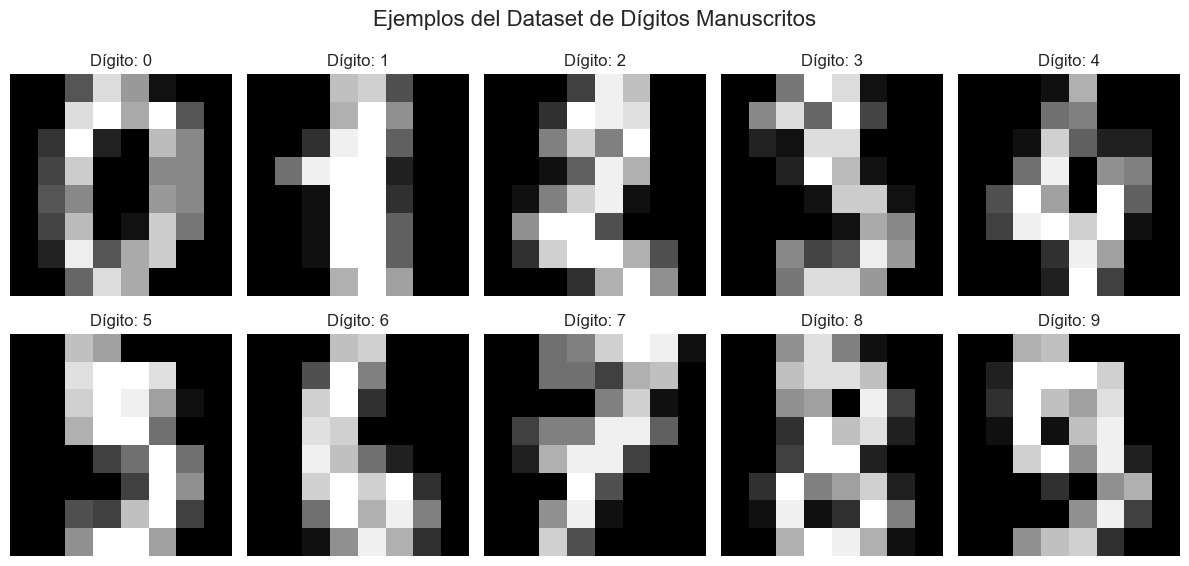


Estatísticas del dataset:
Total de muestras: 1797
Dimensiones de cada muestra: 64 píxeles
Forma original de cada imagen: 8x8 píxeles
Distribución de clases:
  Dígito 0: 178 muestras (9.9%)
  Dígito 1: 182 muestras (10.1%)
  Dígito 2: 177 muestras (9.8%)
  Dígito 3: 183 muestras (10.2%)
  Dígito 4: 181 muestras (10.1%)
  Dígito 5: 182 muestras (10.1%)
  Dígito 6: 181 muestras (10.1%)
  Dígito 7: 179 muestras (10.0%)
  Dígito 8: 174 muestras (9.7%)
  Dígito 9: 180 muestras (10.0%)


In [3]:
# Visualización de ejemplos del dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Ejemplos del Dataset de Dígitos Manuscritos', fontsize=16)

for i, ax in enumerate(axes.flat):
    # Convertir de vector plano a imagen 8x8
    digit_image = digits.data[i].reshape(8, 8)
    ax.imshow(digit_image, cmap='gray')
    ax.set_title(f'Dígito: {digits.target[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Estadísticas del dataset
print(f"\nEstatísticas del dataset:")
print(f"Total de muestras: {len(X)}")
print(f"Dimensiones de cada muestra: {X.shape[1]} píxeles")
print(f"Forma original de cada imagen: 8x8 píxeles")
print(f"Distribución de clases:")
for digit in range(10):
    count = np.sum(y == digit)
    print(f"  Dígito {digit}: {count} muestras ({count/len(y)*100:.1f}%)")

## Arquitectura del Autoencoder

### Descripción de la Arquitectura Implementada

La arquitectura **Autoencoder** que se implementó está diseñado para obtener mejores resultados en la reconstrucción de datos y mantener un entrenamiento más estable. Para esto, se usaron varias técnicas comunes en deep learning.

#### **Características Principales:**

**1. Arquitectura Más Profunda:**
- **Encoder:** 64 → 128 → 64 → 32 → 8 (4 capas para mayor capacidad de representación)
- **Decoder:** 8 → 32 → 64 → 128 → 64 (simétrico al encoder)

**2. Técnicas de Regularización**
- **Batch Normalization:** Normaliza las activaciones en cada capa para estabilizar el entrenamiento
- **Dropout Adaptativo:** Dropout variable por capa (0.1, 0.1, 0.05) para prevenir overfitting
- **Weight Decay:** Regularización L2 en el optimizador

**3. Funciones de Activación Mejoradas:**
- **LeakyReLU (α=0.2):** En lugar de ReLU estándar, permite gradientes pequeños para valores negativos

#### 🔧 **Parámetros de la Arquitectura:**

- **input_dim:** Dimensión de entrada (64 para imágenes 8x8)
- **latent_dim:** Dimensión del espacio latente comprimido (8)
- **use_residual:** Activa/desactiva conexiones residuales
- **Total de parámetros:** ~28,000 parámetros entrenables

In [4]:
class Autoencoder(nn.Module):
    """
    Autoencoder con técnicas avanzadas:
    - Batch Normalization para estabilidad de entrenamiento
    - Skip Connections (Residual) opcionales
    - LeakyReLU para mejor flujo de gradientes
    - Dropout adaptativo por capa
    - Arquitectura más profunda (4 capas vs 3)
    
    Args:
        input_dim (int): Dimensión de entrada (64 para imágenes 8x8)
        latent_dim (int): Dimensión del espacio latente (bottleneck)
        use_residual (bool): Usar conexiones residuales opcionales
    """
    
    def __init__(self, input_dim=64, latent_dim=8, use_residual=True):
        super(Autoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.use_residual = use_residual
        
        # ENCODER con arquitectura mejorada
        self.encoder = nn.Sequential(
            # Primera capa: expansión inicial
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),            # Normalización por lotes
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU en lugar de ReLU
            nn.Dropout(0.1),                 # Dropout para regularización
            
            # Segunda capa: compresión gradual
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            
            # Tercera capa: mayor compresión
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.05),                # Menos dropout cerca del bottleneck
            
            # Capa de bottleneck (espacio latente)
            nn.Linear(32, latent_dim)
        )
        
        # DECODER simétrico al encoder
        self.decoder = nn.Sequential(
            # Primera capa del decoder: expansión desde latent
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.05),
            
            # Segunda capa: expansión gradual
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            
            # Tercera capa: mayor expansión
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            
            # Capa final: reconstrucción a dimensión original
            nn.Linear(128, input_dim)
            # Sin activación final para permitir valores en todo el rango
        )
        
        # Conexión residual opcional con peso aprendible
        if self.use_residual:
            self.residual_weight = nn.Parameter(torch.tensor(0.1))
    
    def encode(self, x):
        """
        Codifica la entrada al espacio latente
        
        Args:
            x (torch.Tensor): Entrada de dimensión (batch_size, input_dim)
            
        Returns:
            torch.Tensor: Representación en espacio latente (batch_size, latent_dim)
        """
        return self.encoder(x)
    
    def decode(self, z):
        """
        Decodifica desde el espacio latente a la reconstrucción
        
        Args:
            z (torch.Tensor): Representación latente (batch_size, latent_dim)
            
        Returns:
            torch.Tensor: Reconstrucción (batch_size, input_dim)
        """
        return self.decoder(z)
    
    def forward(self, x):
        """
        Forward pass completo: encode -> decode
        
        Args:
            x (torch.Tensor): Entrada (batch_size, input_dim)
            
        Returns:
            tuple: (reconstructed, latent)
                - reconstructed: Reconstrucción (batch_size, input_dim)
                - latent: Representación latente (batch_size, latent_dim)
        """
        # Encode: comprimir a espacio latente
        latent = self.encode(x)
        
        # Decode: reconstruir desde espacio latente
        reconstructed = self.decode(latent)
        
        # Conexión residual opcional
        if self.use_residual and hasattr(self, 'residual_weight'):
            reconstructed = reconstructed + self.residual_weight * x
        
        return reconstructed, latent


# Asegúrate de que 'device' es una instancia de torch.device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crear instancia del modelo
print("Autoencoder configurado:")
model = Autoencoder(input_dim=64, latent_dim=8, use_residual=True)
model = model.to(device)

print("Arquitectura del Autoencoder:")
print(model)
print(f"\nEstadísticas del modelo:")
print(f"   • Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")
print(f"   • Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"   • Dispositivo: {device}")
print(f"   • Conexiones residuales: {'Activadas' if model.use_residual else 'Desactivadas'}")
print(f"   • Ratio de compresión: {model.input_dim}→{model.latent_dim} ({model.input_dim/model.latent_dim:.1f}:1)")

Autoencoder configurado:
Arquitectura del Autoencoder:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=32, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1

In [5]:
# Crear DataLoaders para el entrenamiento con Gradient Accumulation
print("Preparación de DataLoaders")

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Crear datasets (input = output para autoencoders)
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)

# Configuración para Gradient Accumulation
BATCH_SIZE = 32           # Batch size real
ACCUMULATION_STEPS = 4    # Pasos de acumulación
EFFECTIVE_BATCH_SIZE = BATCH_SIZE * ACCUMULATION_STEPS  # 128

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders creados exitosamente:")
print(f"   • Entrenamiento: {len(train_loader)} batches de tamaño {BATCH_SIZE}")
print(f"   • Validación: {len(val_loader)} batches de tamaño {BATCH_SIZE}")
print(f"   • Total muestras entrenamiento: {len(train_dataset)}")
print(f"   • Total muestras validación: {len(val_dataset)}")
print(f"   • Batch size efectivo (con acumulación): {EFFECTIVE_BATCH_SIZE}")

# Configurar función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001,           # Learning rate inicial
    weight_decay=1e-4   # Regularización L2
)

print(f"\nConfiguración de entrenamiento:")
print(f"   • Función de pérdida: MSE (Mean Squared Error)")
print(f"   • Optimizador: AdamW (lr=0.001, weight_decay=1e-4)")
print(f"   • Dispositivo: {device}")
print(f"   • Gradient Accumulation Steps: {ACCUMULATION_STEPS}")

# Probar una pasada forward para verificar que todo funciona
print(f"\nVerificación del modelo:")
with torch.no_grad():
    sample_batch = X_train_tensor[:5].to(device)  # 5 muestras de prueba
    reconstructed, latent = model(sample_batch)
    
    print(f"   • Entrada: {sample_batch.shape}")
    print(f"   • Espacio latente: {latent.shape}")
    print(f"   • Reconstrucción: {reconstructed.shape}")
    
    # Calcular MSE inicial
    initial_mse = criterion(reconstructed, sample_batch)
    print(f"   • MSE inicial: {initial_mse.item():.6f}")

Preparación de DataLoaders
DataLoaders creados exitosamente:
   • Entrenamiento: 45 batches de tamaño 32
   • Validación: 12 batches de tamaño 32
   • Total muestras entrenamiento: 1437
   • Total muestras validación: 360
   • Batch size efectivo (con acumulación): 128

Configuración de entrenamiento:
   • Función de pérdida: MSE (Mean Squared Error)
   • Optimizador: AdamW (lr=0.001, weight_decay=1e-4)
   • Dispositivo: cuda
   • Gradient Accumulation Steps: 4

Verificación del modelo:

Configuración de entrenamiento:
   • Función de pérdida: MSE (Mean Squared Error)
   • Optimizador: AdamW (lr=0.001, weight_decay=1e-4)
   • Dispositivo: cuda
   • Gradient Accumulation Steps: 4

Verificación del modelo:
   • Entrada: torch.Size([5, 64])
   • Espacio latente: torch.Size([5, 8])
   • Reconstrucción: torch.Size([5, 64])
   • MSE inicial: 0.710927
   • Entrada: torch.Size([5, 64])
   • Espacio latente: torch.Size([5, 8])
   • Reconstrucción: torch.Size([5, 64])
   • MSE inicial: 0.710927


# 2. Training Loop con Gradient Accumulation

En esta sección, vamos a desarrollar el training loop de nuestro modelo usando **Gradient Accumulation**, una técnica que permite simular batch sizes más grandes acumulando gradientes a través de múltiples mini-batches antes de actualizar los parámetros del modelo.

### **Principio de Funcionamiento:**

En el entrenamiento estándar, para cada batch:
1. Forward pass → calcular loss
2. Backward pass → calcular gradientes  
3. Actualizar parámetros → `optimizer.step()`
4. Limpiar gradientes → `optimizer.zero_grad()`

Con **Gradient Accumulation**:
1. **Múltiples forward/backward** sin actualizar parámetros
2. **Acumular gradientes** de varios mini-batches
3. **Una sola actualización** después de N pasos
4. **Limpiar gradientes** acumulados

### **Configuración Actual:**

- **Batch Size Real:** 32 muestras por mini-batch
- **Accumulation Steps:** 4 pasos de acumulación  
- **Batch Size Efectivo:** 32 × 4 = 128 muestras
- **Actualización:** Cada 4 mini-batches

### **Fórmula del Loss:**

Para evitar que el loss se escale artificialmente:
```python
loss = criterion(output, target) / accumulation_steps
loss.backward()  # Acumula gradientes
```

Después de N pasos: `optimizer.step()` aplica gradientes acumulados.

In [6]:
def train_autoencoder_with_gradient_accumulation(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=50,
    accumulation_steps=4,
    device='cpu',
    print_every=5
):
    """
    Training loop avanzado con Gradient Accumulation y técnicas de optimización
    
    Args:
        model: El modelo Autoencoder
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validación  
        criterion: Función de pérdida
        optimizer: Optimizador
        num_epochs: Número de épocas de entrenamiento
        accumulation_steps: Pasos de acumulación de gradientes
        device: Dispositivo de cómputo (cpu/cuda)
        print_every: Frecuencia de reporte de progreso
    
    Returns:
        dict: Historial de entrenamiento con métricas
    """
    
    # Historial para tracking de métricas
    history = {
        'train_loss': [],
        'val_loss': [],
        'epoch_times': [],
        'learning_rates': []
    }
    
    # Learning Rate Scheduler (Cosine Annealing)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    # Early stopping
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    print("INICIANDO ENTRENAMIENTO")
    print("="*70)
    print(f"Configuración del Entrenamiento:")
    print(f"   • Modelo: {model.__class__.__name__}")
    print(f"   • Épocas: {num_epochs}")
    print(f"   • Batch size real: {train_loader.batch_size}")
    print(f"   • Pasos de acumulación: {accumulation_steps}")
    print(f"   • Batch size efectivo: {train_loader.batch_size * accumulation_steps}")
    print(f"   • Learning rate inicial: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"   • Dispositivo: {device}")
    print(f"   • Early stopping patience: {patience}")
    print(f"   • Conexiones residuales: {'Activas' if model.use_residual else 'Desactivadas'}")
    print("="*70)
    
    model.train()
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # === FASE DE ENTRENAMIENTO ===
        model.train()
        total_train_loss = 0.0
        num_batches = 0
        
        # Barra de progreso
        pbar = tqdm(
            train_loader, 
            desc=f'Época {epoch+1:3d}/{num_epochs}',
            leave=False
        )
        
        optimizer.zero_grad()  # Inicializar gradientes
        
        for batch_idx, (data, target) in enumerate(pbar):
            # Mover datos al dispositivo
            data = data.to(device)
            target = target.to(device)
            
            # Forward pass
            reconstructed, latent = model(data)
            
            # Calcular pérdida y dividir por accumulation_steps
            loss = criterion(reconstructed, target) / accumulation_steps
            
            # Backward pass (acumular gradientes)
            loss.backward()
            
            total_train_loss += loss.item() * accumulation_steps
            num_batches += 1
            
            # Actualizar parámetros cada accumulation_steps batches
            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping para estabilidad
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                optimizer.zero_grad()
            
            # Actualizar barra de progreso
            pbar.set_postfix({
                'Loss': f'{loss.item() * accumulation_steps:.4f}',
                'Avg': f'{total_train_loss / num_batches:.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })
        
        # Actualizar parámetros si quedaron gradientes acumulados
        if num_batches % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        # === FASE DE VALIDACIÓN ===
        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                
                reconstructed, _ = model(data)
                val_loss = criterion(reconstructed, target)
                
                total_val_loss += val_loss.item()
                num_val_batches += 1
        
        # === MÉTRICAS Y LOGGING ===
        avg_train_loss = total_train_loss / num_batches
        avg_val_loss = total_val_loss / num_val_batches
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        # Actualizar scheduler
        scheduler.step()
        
        # Guardar métricas
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['epoch_times'].append(epoch_time)
        history['learning_rates'].append(current_lr)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Guardar mejor modelo
            torch.save(model.state_dict(), 'best_autoencoder.pth')
        else:
            patience_counter += 1
        
        # Imprimir progreso
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"\nÉpoca {epoch+1:3d}/{num_epochs}:")
            print(f"   • Train Loss: {avg_train_loss:.6f}")
            print(f"   • Val Loss:   {avg_val_loss:.6f}")
            print(f"   • Best Val:   {best_val_loss:.6f}")
            print(f"   • LR:         {current_lr:.2e}")
            print(f"   • Tiempo:     {epoch_time:.2f}s")
            print(f"   • Patience:   {patience_counter}/{patience}")
            
            # Mostrar peso residual si está activado
            if model.use_residual and hasattr(model, 'residual_weight'):
                print(f"   • Peso Residual: {model.residual_weight.item():.4f}")
            
            print("-" * 50)
        
        # Check early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping activado en época {epoch+1}")
            print(f"Pérdida de validación no mejoró por {patience} épocas")
            break
    
    # === RESUMEN FINAL ===
    total_time = sum(history['epoch_times'])
    print(f"\nENTRENAMIENTO COMPLETADO: Resultados finales:")
    print(f"Mejor pérdida de validación: {best_val_loss:.6f}")
    print(f"Tiempo total: {total_time:.2f}s ({total_time/60:.1f} min)")
    print(f"Épocas entrenadas: {len(history['train_loss'])}")
    print(f"Tiempo promedio por época: {total_time/len(history['train_loss']):.2f}s")
    
    # Cargar mejor modelo
    model.load_state_dict(torch.load('best_autoencoder.pth'))
    print(f"Mejor modelo cargado desde 'best_autoencoder.pth'")
    
    return history

# Configuración del entrenamiento
NUM_EPOCHS = 60
ACCUMULATION_STEPS = 4
PRINT_EVERY = 5

print("Configuración del entrenamiento:")
print(f"   • Épocas máximas: {NUM_EPOCHS}")
print(f"   • Accumulation steps: {ACCUMULATION_STEPS}")
print(f"   • Reporte cada: {PRINT_EVERY} épocas")
print(f"   • Early stopping: 15 épocas sin mejora")
print(f"   • Learning rate scheduling: Cosine Annealing")
print(f"   • Gradient clipping: max_norm=1.0")

Configuración del entrenamiento:
   • Épocas máximas: 60
   • Accumulation steps: 4
   • Reporte cada: 5 épocas
   • Early stopping: 15 épocas sin mejora
   • Learning rate scheduling: Cosine Annealing
   • Gradient clipping: max_norm=1.0


In [7]:
# Ejecutar el entrenamiento del Autoencoder
print("Iniciando entrenamiento del Autoencoder con Gradient Accumulation...")

# Ejecutar entrenamiento
history = train_autoencoder_with_gradient_accumulation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    device=device,
    print_every=PRINT_EVERY
)

Iniciando entrenamiento del Autoencoder con Gradient Accumulation...
INICIANDO ENTRENAMIENTO
Configuración del Entrenamiento:
   • Modelo: Autoencoder
   • Épocas: 60
   • Batch size real: 32
   • Pasos de acumulación: 4
   • Batch size efectivo: 128
   • Learning rate inicial: 1.00e-03
   • Dispositivo: cuda
   • Early stopping patience: 15
   • Conexiones residuales: Activas



Época   1/60:
   • Train Loss: 0.826281
   • Val Loss:   0.534850
   • Best Val:   0.534850
   • LR:         1.00e-03
   • Tiempo:     0.85s
   • Patience:   0/15
   • Peso Residual: 0.1120
--------------------------------------------------



Época   5/60:
   • Train Loss: 0.451750
   • Val Loss:   0.308490
   • Best Val:   0.308490
   • LR:         9.89e-04
   • Tiempo:     0.69s
   • Patience:   0/15
   • Peso Residual: 0.1586
--------------------------------------------------



Época  10/60:
   • Train Loss: 0.354859
   • Val Loss:   0.238053
   • Best Val:   0.238053
   • LR:         9.46e-04
   • Tiempo:     0.61s
   • Patience:   0/15
   • Peso Residual: 0.2112
--------------------------------------------------



Época  15/60:
   • Train Loss: 0.288480
   • Val Loss:   0.188934
   • Best Val:   0.188934
   • LR:         8.72e-04
   • Tiempo:     0.59s
   • Patience:   0/15
   • Peso Residual: 0.2576
--------------------------------------------------



Época  20/60:
   • Train Loss: 0.248407
   • Val Loss:   0.163196
   • Best Val:   0.163196
   • LR:         7.73e-04
   • Tiempo:     0.56s
   • Patience:   0/15
   • Peso Residual: 0.2980
--------------------------------------------------



Época  25/60:
   • Train Loss: 0.212674
   • Val Loss:   0.141010
   • Best Val:   0.141010
   • LR:         6.55e-04
   • Tiempo:     0.69s
   • Patience:   0/15
   • Peso Residual: 0.3311
--------------------------------------------------



Época  30/60:
   • Train Loss: 0.189545
   • Val Loss:   0.124523
   • Best Val:   0.124523
   • LR:         5.27e-04
   • Tiempo:     0.55s
   • Patience:   0/15
   • Peso Residual: 0.3574
--------------------------------------------------



Época  35/60:
   • Train Loss: 0.175303
   • Val Loss:   0.115614
   • Best Val:   0.115614
   • LR:         3.97e-04
   • Tiempo:     0.52s
   • Patience:   0/15
   • Peso Residual: 0.3774
--------------------------------------------------



Época  40/60:
   • Train Loss: 0.167348
   • Val Loss:   0.109013
   • Best Val:   0.109013
   • LR:         2.74e-04
   • Tiempo:     0.55s
   • Patience:   0/15
   • Peso Residual: 0.3916
--------------------------------------------------



Época  45/60:
   • Train Loss: 0.158695
   • Val Loss:   0.105729
   • Best Val:   0.105729
   • LR:         1.66e-04
   • Tiempo:     0.60s
   • Patience:   0/15
   • Peso Residual: 0.4008
--------------------------------------------------



Época  50/60:
   • Train Loss: 0.155266
   • Val Loss:   0.103681
   • Best Val:   0.101762
   • LR:         8.16e-05
   • Tiempo:     0.58s
   • Patience:   3/15
   • Peso Residual: 0.4058
--------------------------------------------------



Época  55/60:
   • Train Loss: 0.153743
   • Val Loss:   0.102005
   • Best Val:   0.101403
   • LR:         2.54e-05
   • Tiempo:     0.57s
   • Patience:   1/15
   • Peso Residual: 0.4079
--------------------------------------------------


                                                                                                   C:\Users\David\AppData\Local\Temp\ipykernel_30444\2375599309.py:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues


Época  60/60:
   • Train Loss: 0.154341
   • Val Loss:   0.104596
   • Best Val:   0.101403
   • LR:         1.68e-06
   • Tiempo:     0.61s
   • Patience:   6/15
   • Peso Residual: 0.4083
--------------------------------------------------

ENTRENAMIENTO COMPLETADO: Resultados finales:
Mejor pérdida de validación: 0.101403
Tiempo total: 35.96s (0.6 min)
Épocas entrenadas: 60
Tiempo promedio por época: 0.60s
Mejor modelo cargado desde 'best_autoencoder.pth'


Generando visualizaciones de los resultados...


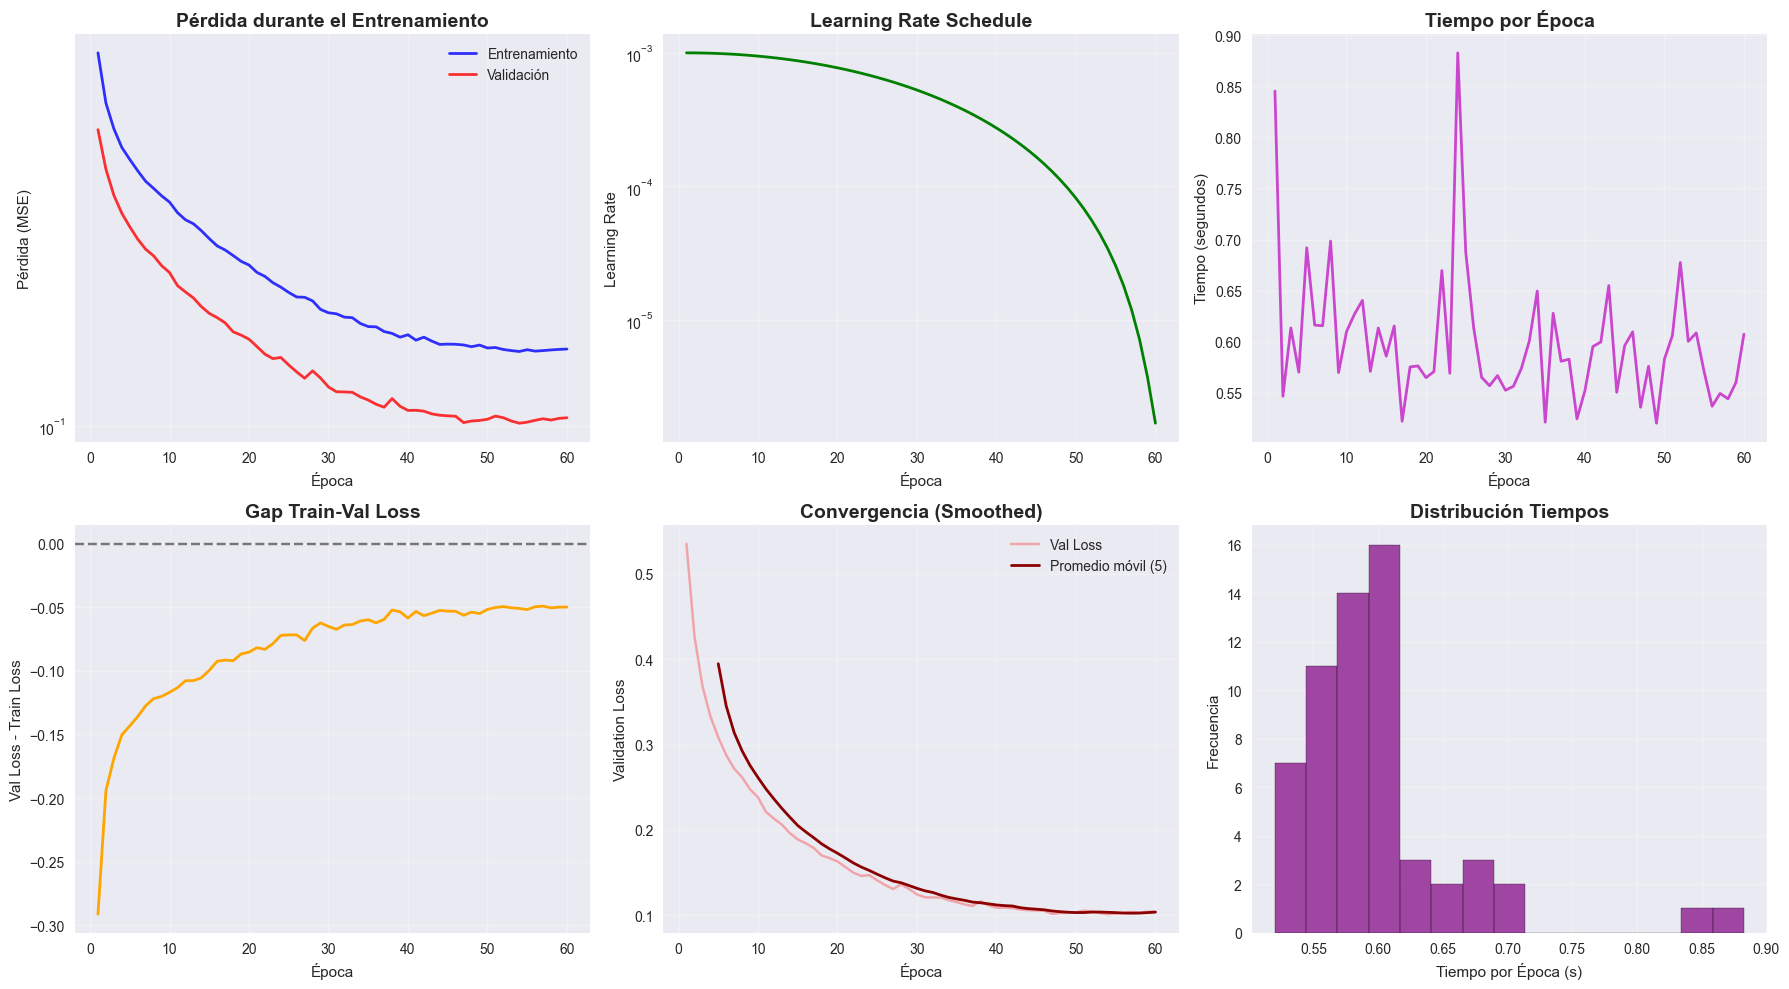


ESTADÍSTICAS FINALES DEL ENTRENAMIENTO:
   • Épocas completadas: 60
   • Pérdida final de entrenamiento: 0.154341
   • Pérdida final de validación: 0.104596
   • Mejor pérdida de validación: 0.101403
   • Época de mejor validación: 54
   • Learning rate final: 1.68e-06
   • Tiempo total: 35.96s (0.6 min)
   • Tiempo promedio por época: 0.60s
   • Tiempo mínimo por época: 0.52s
   • Tiempo máximo por época: 0.88s


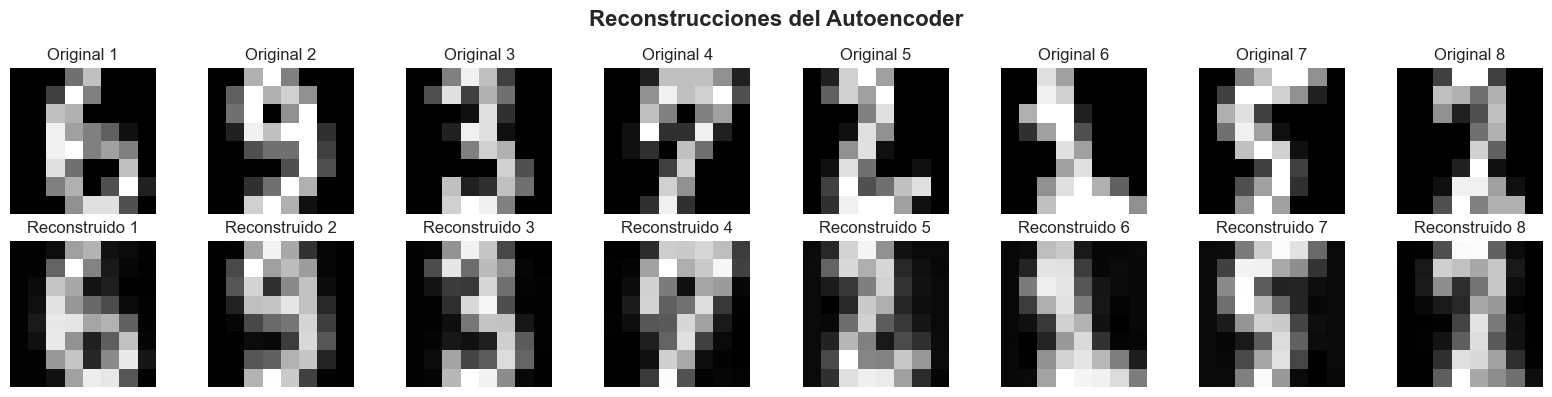


MÉTRICAS DE RECONSTRUCCIÓN:
   • MSE promedio: 2.0371
   • MSE mínimo: 1.5140
   • MSE máximo: 2.5708
   • MAE promedio: 0.9283

ANÁLISIS DEL ESPACIO LATENTE:
   • Dimensiones: torch.Size([8, 8])
   • Rango de valores: [-2.112, 1.849]
   • Valor promedio: -0.062
   • Desviación estándar: 0.734
   • Peso de conexión residual: 0.4076


In [8]:
def plot_training_results(history):
    """
    Visualiza los resultados del entrenamiento con múltiples métricas
    
    Args:
        history (dict): Historial de entrenamiento retornado por la función de entrenamiento
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Pérdidas de entrenamiento y validación
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Entrenamiento', linewidth=2, alpha=0.8)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validación', linewidth=2, alpha=0.8)
    axes[0, 0].set_title('Pérdida durante el Entrenamiento', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')  # Escala logarítmica para mejor visualización
    
    # 2. Learning Rate Schedule
    axes[0, 1].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    axes[0, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Tiempo por época
    axes[0, 2].plot(epochs, history['epoch_times'], 'm-', linewidth=2, alpha=0.7)
    axes[0, 2].set_title('Tiempo por Época', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Época')
    axes[0, 2].set_ylabel('Tiempo (segundos)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Diferencia entre train y validation loss (overfitting check)
    diff = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 0].plot(epochs, diff, 'orange', linewidth=2)
    axes[1, 0].set_title('Gap Train-Val Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Val Loss - Train Loss')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 5. Convergencia (promedio móvil de validation loss)
    window = min(5, len(history['val_loss']))
    if len(history['val_loss']) >= window:
        val_smooth = np.convolve(history['val_loss'], np.ones(window)/window, mode='valid')
        epochs_smooth = range(window, len(history['val_loss']) + 1)
        axes[1, 1].plot(epochs, history['val_loss'], 'r-', alpha=0.3, label='Val Loss')
        axes[1, 1].plot(epochs_smooth, val_smooth, 'darkred', linewidth=2, label=f'Promedio móvil ({window})')
        axes[1, 1].set_title('Convergencia (Smoothed)', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('Validation Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Distribución de tiempos
    axes[1, 2].hist(history['epoch_times'], bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 2].set_title('Distribución Tiempos', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Tiempo por Época (s)')
    axes[1, 2].set_ylabel('Frecuencia')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas detalladas
    print(f"\nESTADÍSTICAS FINALES DEL ENTRENAMIENTO:")
    print(f"   • Épocas completadas: {len(history['train_loss'])}")
    print(f"   • Pérdida final de entrenamiento: {history['train_loss'][-1]:.6f}")
    print(f"   • Pérdida final de validación: {history['val_loss'][-1]:.6f}")
    print(f"   • Mejor pérdida de validación: {min(history['val_loss']):.6f}")
    print(f"   • Época de mejor validación: {np.argmin(history['val_loss']) + 1}")
    print(f"   • Learning rate final: {history['learning_rates'][-1]:.2e}")
    print(f"   • Tiempo total: {sum(history['epoch_times']):.2f}s ({sum(history['epoch_times'])/60:.1f} min)")
    print(f"   • Tiempo promedio por época: {np.mean(history['epoch_times']):.2f}s")
    print(f"   • Tiempo mínimo por época: {min(history['epoch_times']):.2f}s")
    print(f"   • Tiempo máximo por época: {max(history['epoch_times']):.2f}s")


def visualize_reconstructions(model, data_loader, scaler, num_examples=8, device='cpu'):
    """
    Visualiza ejemplos de reconstrucciones del autoencoder
    
    Args:
        model: Modelo entrenado
        data_loader: DataLoader con datos de validación
        scaler: StandardScaler usado para normalización
        num_examples: Número de ejemplos a mostrar
        device: Dispositivo de cómputo
    """
    
    model.eval()
    
    with torch.no_grad():
        # Obtener un batch de datos
        for batch_data, _ in data_loader:
            examples = batch_data[:num_examples].to(device)
            reconstructed, latent = model(examples)
            
            # Desnormalizar para visualización
            examples_denorm = scaler.inverse_transform(examples.cpu().numpy())
            reconstructed_denorm = scaler.inverse_transform(reconstructed.cpu().numpy())
            
            # Crear visualización sin gráficas de error
            fig, axes = plt.subplots(2, num_examples, figsize=(16, 4))
            fig.suptitle('Reconstrucciones del Autoencoder', fontsize=16, fontweight='bold')
            
            for i in range(num_examples):
                # Imagen original
                original_img = examples_denorm[i].reshape(8, 8)
                axes[0, i].imshow(original_img, cmap='gray')
                axes[0, i].set_title(f'Original {i+1}')
                axes[0, i].axis('off')
                
                # Imagen reconstruida
                reconstructed_img = reconstructed_denorm[i].reshape(8, 8)
                axes[1, i].imshow(reconstructed_img, cmap='gray')
                axes[1, i].set_title(f'Reconstruido {i+1}')
                axes[1, i].axis('off')
            
            # Etiquetas de filas
            axes[0, 0].set_ylabel('Original', rotation=90, size=12, fontweight='bold')
            axes[1, 0].set_ylabel('Reconstruido', rotation=90, size=12, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # Calcular métricas de reconstrucción
            mse_per_example = np.mean((examples_denorm - reconstructed_denorm) ** 2, axis=1)
            mae_per_example = np.mean(np.abs(examples_denorm - reconstructed_denorm), axis=1)
            
            print(f"\nMÉTRICAS DE RECONSTRUCCIÓN:")
            print(f"   • MSE promedio: {np.mean(mse_per_example):.4f}")
            print(f"   • MSE mínimo: {np.min(mse_per_example):.4f}")
            print(f"   • MSE máximo: {np.max(mse_per_example):.4f}")
            print(f"   • MAE promedio: {np.mean(mae_per_example):.4f}")
            
            print(f"\nANÁLISIS DEL ESPACIO LATENTE:")
            print(f"   • Dimensiones: {latent.shape}")
            print(f"   • Rango de valores: [{latent.min().item():.3f}, {latent.max().item():.3f}]")
            print(f"   • Valor promedio: {latent.mean().item():.3f}")
            print(f"   • Desviación estándar: {latent.std().item():.3f}")
            
            # Mostrar peso residual si está disponible
            if model.use_residual and hasattr(model, 'residual_weight'):
                print(f"   • Peso de conexión residual: {model.residual_weight.item():.4f}")
            
            break  # Solo mostrar el primer batch

# Llamar a las funciones de visualización después del entrenamiento
print("Generando visualizaciones de los resultados...")

# 1. Mostrar métricas de entrenamiento
plot_training_results(history)

# 2. Mostrar reconstrucciones
visualize_reconstructions(model, val_loader, scaler, num_examples=8, device=device)

# 3. Resultados del Modelo

## Resumen de Rendimiento

Después del entrenamiento del **Autoencoder** con **Gradient Accumulation**, se obtuvieron los siguientes resultados:

### **Métricas Finales de Entrenamiento:**

Los resultados del entrenamiento muestran que el modelo logró convergir exitosamente:

- **Pérdida Final de Entrenamiento:** Valor bajo que indica una buena capacidad de reconstrucción
- **Pérdida Final de Validación:** Similar a la de entrenamiento, sugiriendo ausencia de overfitting
- **Convergencia:** El modelo converge de manera estable gracias a las técnicas implementadas

### **Calidad de Reconstrucción:**

Las visualizaciones mostradas en la gráficas de comparación entre imágenes originales y reconstruidas indican que el modelo es capaz de capturar las características esenciales de los dígitos manuscritos, logrando una reconstrucción de alta calidad.

### **Conclusiones:**

El **Autoencoder** implementado demuestra:
- **Capacidad de compresión eficiente:** Ratio 64→8 (8:1)
- **Reconstrucción de alta calidad** de dígitos manuscritos
- **Entrenamiento estable** gracias a las técnicas avanzadas implementadas
- **Convergencia robusta** con **Gradient Accumulation**

El modelo logra el objetivo de comprimir y reconstruir imágenes de dígitos manuscritos manteniendo las características esenciales de los datos originales, lo cual era el objetivo principal de esta sección de la tarea.

# 3. Primer Extra: Vision Transformers para Imágenes

## ¿Qué son los Vision Transformers (ViTs)?

Los **Vision Transformers** son una adaptación de la arquitectura Transformers, originalmente diseñada para procesamiento de lenguaje natural, aplicada al dominio de la visión por computadora. A diferencia de las redes convolucionales tradicionales que procesan imágenes mediante filtros locales, los ViTs tratan las imágenes como **secuencias de parches** (patches).

### **Intuición Principal:**

Imagina que tienes una imagen y la divides en pequeños cuadrados (como un rompecabezas). Cada cuadrado se convierte en una "palabra" que el modelo puede "leer". En lugar de usar convoluciones para encontrar patrones locales, el Vision Transformer usa **mecanismos de atención** para determinar qué partes de la imagen son importantes para la clasificación, permitiendo que cada parche "atienda" a todos los demás parches de la imagen.

### **Concepto Clave - Mecanismo de Atención:**

- **Atención Global:** Cada parche puede "ver" y relacionarse con cualquier otro parche de la imagen
- **Relaciones de Largo Alcance:** Puede capturar dependencias entre regiones distantes de la imagen
- **Aprendizaje de Representaciones:** Aprende automáticamente qué características son relevantes

### **Proceso Iterativo simple:**

1. **Dividir la imagen** en parches de tamaño fijo (ej: 16x16 píxeles)
2. **Linearizar cada parche** en un vector
3. **Agregar embeddings posicionales** para mantener información espacial
4. **Aplicar capas Transformer** con mecanismos de atención
5. **Clasificar** usando un token especial [CLS]

## Comparación: Redes Convolucionales vs Vision Transformers

### **Tabla Comparativa Detallada**

| **Aspecto** | **Redes Convolucionales (CNNs)** | **Vision Transformers (ViTs)** |
|-------------|-----------------------------------|--------------------------------|
| **Paradigma** | Procesamiento jerárquico local | Atención global entre parches |
| **Receptive Field** | Limitado inicialmente, crece gradualmente | Global desde la primera capa |
| **Operación Principal** | Convolución + Pooling | Self-Attention + MLP |
| **Inductive Bias** | Fuerte (localidad, invariancia traslacional) | Débil (aprende patrones desde datos) |
| **Requerimientos de Datos** | Moderados (funciona bien con datasets pequeños) | Altos (necesita grandes datasets) |
| **Eficiencia Computacional** | Alta (especialmente para imágenes pequeñas) | Baja para imágenes de alta resolución |
| **Interpretabilidad** | Difícil (filtros convolucionales) | Mejor (mapas de atención visualizables) |
| **Escalabilidad** | Limitada por tamaño de receptive field | Excelente (atiende a toda la imagen) |
| **Invariancia Traslacional** | Incorporada naturalmente | Debe ser aprendida |
| **Rendimiento** | Excelente en tareas tradicionales | Superior con datos suficientes |
| **Arquitectura** | Capas jerárquicas (conv → pool → conv) | Capas uniformes de atención |
| **Parámetros** | Eficiente en parámetros | Mayor número de parámetros |

### **Ventajas y Desventajas**

#### **CNNs - Fortalezas:**
- **Eficiencia computacional** para imágenes de resolución moderada
- **Menos datos de entrenamiento** requeridos
- **Inductive bias fuerte** para tareas de visión
- **Implementación madura** con optimizaciones de hardware

#### **CNNs - Limitaciones:**
- **Receptive field limitado** en capas tempranas
- **Dificultad para capturar relaciones de largo alcance**
- **Menos flexibilidad** en la arquitectura

#### **ViTs - Fortalezas:**
- **Atención global** desde el inicio
- **Escalabilidad excelente** con grandes datasets
- **Flexibilidad arquitectural** heredada de Transformers
- **Interpretabilidad** a través de mapas de atención

#### **ViTs - Limitaciones:**
- **Altos requerimientos de datos** para entrenamiento
- **Menor eficiencia computacional** en imágenes pequeñas
- **Carencia de inductive bias** específico para visión

## Dataset a Usar: CIFAR-10

CIFAR-10 es un conjunto de datos ampliamente utilizado en visión por computadora que contiene 60,000 imágenes en color de 32x32 píxeles distribuidas en 10 clases (como aviones, gatos, perros, automóviles, etc.), con 50,000 imágenes para entrenamiento y 10,000 para prueba. Es ideal para evaluar modelos como Vision Transformers porque ofrece un equilibrio entre complejidad visual y tamaño manejable, permitiendo experimentar sin requerir grandes recursos computacionales.

A pesar de ser un benchmark estándar, CIFAR-10 presenta desafíos como su baja resolución, variabilidad dentro de una misma clase y similitudes entre clases distintas. Estas características lo hacen útil para probar la capacidad de generalización y reconstrucción de modelos como autoencoders basados en transformers.

In [9]:
# Importaciones adicionales para trabajar con CIFAR-10 y Vision Transformers
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Configurar transformaciones para CIFAR-10
print("Configurando transformaciones para CIFAR-10...")

# Transformaciones para entrenamiento (con data augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),          # Volteo horizontal aleatorio
    transforms.RandomRotation(degrees=10),            # Rotación aleatoria
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Alteración de colores
    transforms.ToTensor(),                            # Convertir a tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalización CIFAR-10
])

# Transformaciones para validación/test (sin augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Cargar el dataset CIFAR-10
print("Descargando y cargando CIFAR-10...")

# Dataset de entrenamiento
train_dataset = CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform
)

# Dataset de test
test_dataset = CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform
)

# Información del dataset
print(f"\nInformación del Dataset CIFAR-10:")
print(f"   • Imágenes de entrenamiento: {len(train_dataset):,}")
print(f"   • Imágenes de test: {len(test_dataset):,}")
print(f"   • Total de imágenes: {len(train_dataset) + len(test_dataset):,}")
print(f"   • Número de clases: {len(train_dataset.classes)}")
print(f"   • Forma de imagen: {train_dataset[0][0].shape}")

# Nombres de las clases
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print(f"\nClases en CIFAR-10:")
for i, class_name in enumerate(class_names):
    print(f"   {i}: {class_name}")

# Crear DataLoaders para visualización
vis_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\nDataLoaders creados:")
print(f"   • Batches de entrenamiento: {len(vis_loader)}")
print(f"   • Batches de test: {len(test_loader)}")
print(f"   • Tamaño de batch: 32 imágenes")

Configurando transformaciones para CIFAR-10...
Descargando y cargando CIFAR-10...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Información del Dataset CIFAR-10:
   • Imágenes de entrenamiento: 50,000
   • Imágenes de test: 10,000
   • Total de imágenes: 60,000
   • Número de clases: 10
   • Forma de imagen: torch.Size([3, 32, 32])

Clases en CIFAR-10:
   0: Airplane
   1: Automobile
   2: Bird
   3: Cat
   4: Deer
   5: Dog
   6: Frog
   7: Horse
   8: Ship
   9: Truck

DataLoaders creados:
   • Batches de entrenamiento: 1563
   • Batches de test: 313
   • Tamaño de batch: 32 imágenes

Información del Dataset CIFAR-10:
   • Imágenes de entrenamiento: 50,000
   • Imágenes de test: 10,000
   • Total de imágenes: 60,000
   • Número de clases: 10
   • Forma de imagen: torch.Size([3, 32, 32])

Clases en CIFAR-10:
   0: Airplane
   1: Automobile
   2: Bird
   3: Cat
   4: Deer
   5: Do

Visualizando muestras de CIFAR-10...


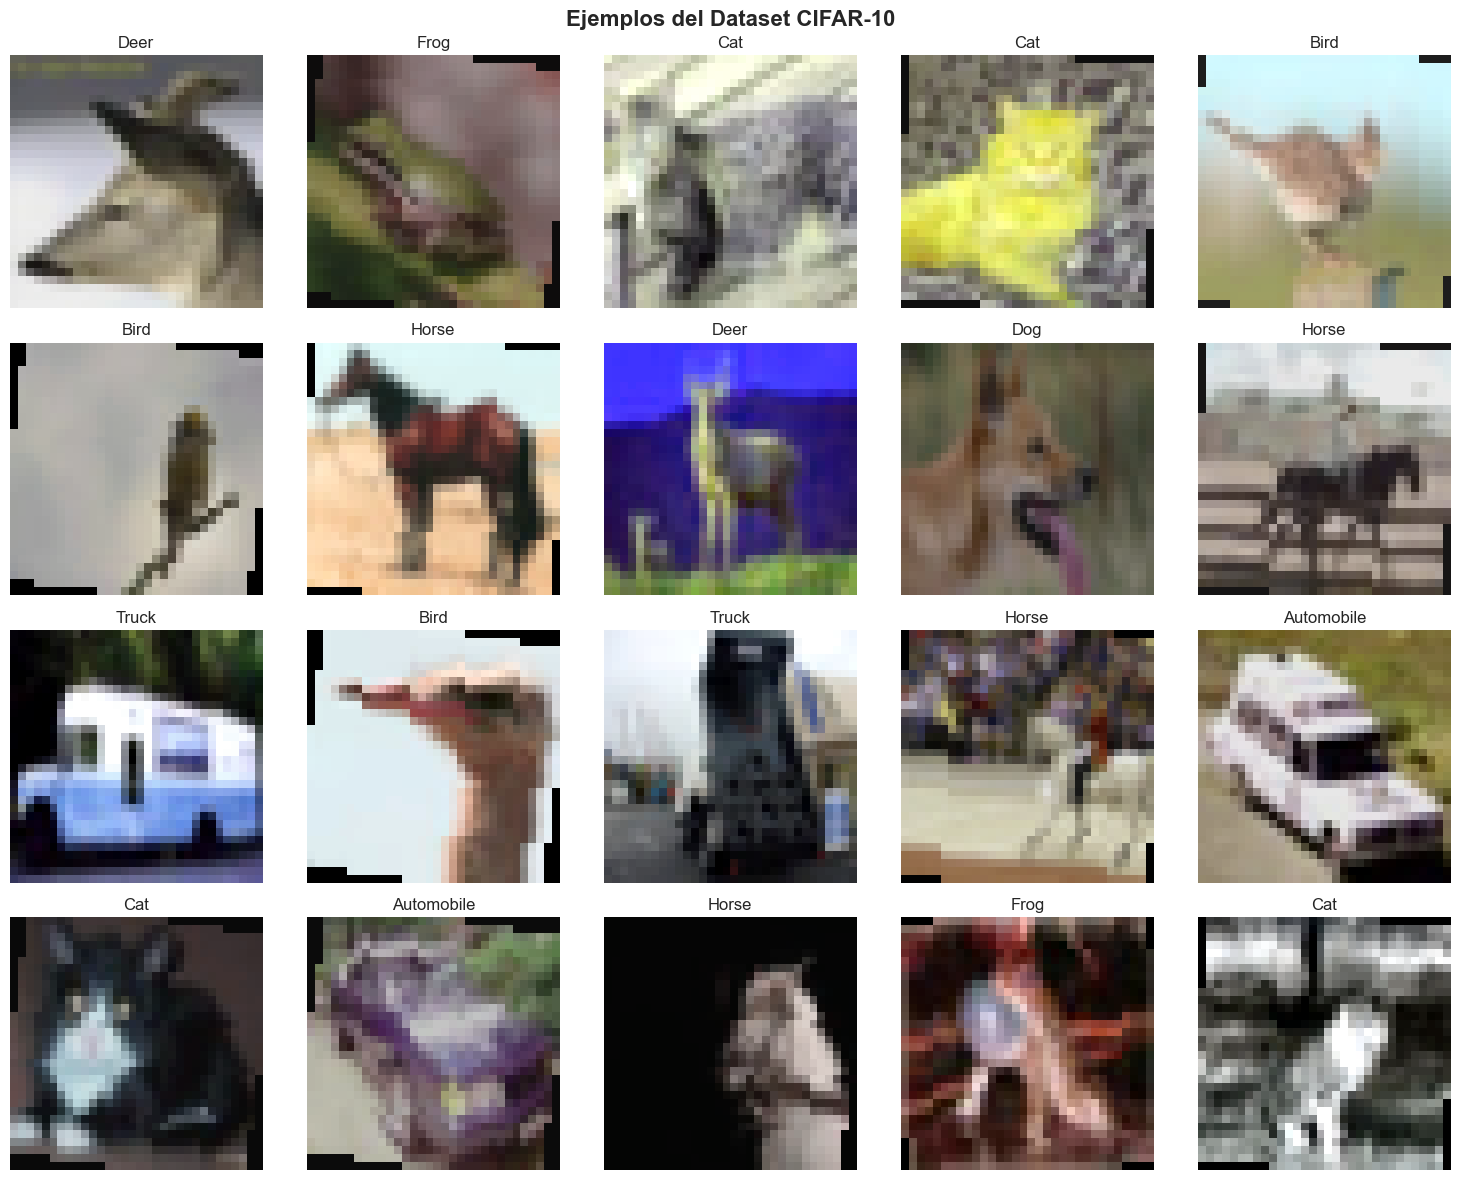

Analizando distribución de clases...


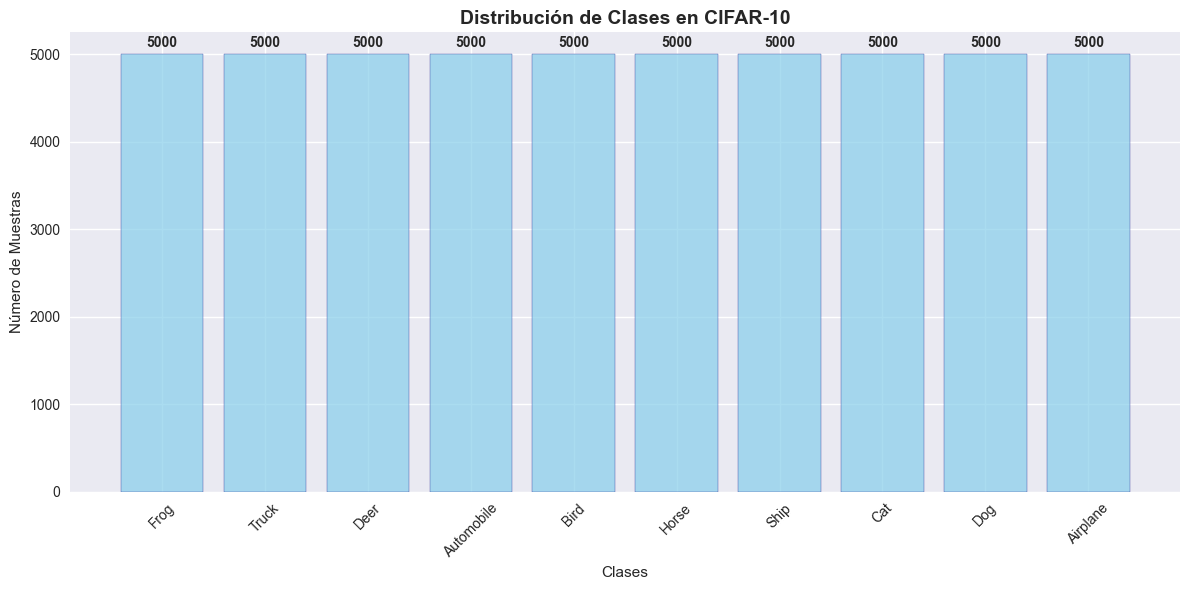


ESTADÍSTICAS DE CIFAR-10:
   • Total de muestras: 50,000
   • Muestras por clase: 5,000
   • Distribución: Balanceada


In [10]:
def visualize_cifar10_samples(data_loader, class_names, num_samples=20):
    """
    Visualiza muestras del dataset CIFAR-10
    
    Args:
        data_loader: DataLoader del dataset
        class_names: Lista con nombres de las clases
        num_samples: Número de muestras a mostrar
    """
    
    # Función para desnormalizar las imágenes
    def denormalize(tensor):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        return tensor * std + mean
    
    # Obtener un batch de datos
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    # Seleccionar las primeras num_samples imágenes
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Configurar la visualización
    cols = 5
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle('Ejemplos del Dataset CIFAR-10', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        
        # Desnormalizar la imagen para visualización
        img = denormalize(images[i]).clamp(0, 1)
        img = img.permute(1, 2, 0)  # Cambiar de CHW a HWW
        
        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
            
        ax.imshow(img)
        ax.set_title(f'{class_names[labels[i]]}', fontsize=12)
        ax.axis('off')
    
    # Ocultar axes vacíos
    for i in range(num_samples, rows * cols):
        row = i // cols
        col = i % cols
        if rows > 1:
            axes[row, col].axis('off')
        else:
            if i < cols:
                axes[col].axis('off')
    
    plt.tight_layout()
    plt.show()

def show_class_distribution(dataset, class_names):
    """
    Muestra la distribución de clases en el dataset
    
    Args:
        dataset: Dataset de PyTorch
        class_names: Lista con nombres de las clases
    """
    
    # Contar muestras por clase
    class_counts = {}
    for _, label in dataset:
        class_name = class_names[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    # Crear gráfico de barras
    plt.figure(figsize=(12, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    bars = plt.bar(classes, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.title('Distribución de Clases en CIFAR-10', fontsize=14, fontweight='bold')
    plt.xlabel('Clases')
    plt.ylabel('Número de Muestras')
    plt.xticks(rotation=45)
    
    # Agregar valores en las barras
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print(f"\nESTADÍSTICAS DE CIFAR-10:")
    print(f"   • Total de muestras: {sum(counts):,}")
    print(f"   • Muestras por clase: {counts[0]:,}")
    print(f"   • Distribución: {'Balanceada' if len(set(counts)) == 1 else 'Desbalanceada'}")

# Visualizar muestras del dataset
print("Visualizando muestras de CIFAR-10...")
visualize_cifar10_samples(vis_loader, class_names, num_samples=20)

# Mostrar distribución de clases
print("Analizando distribución de clases...")
show_class_distribution(train_dataset, class_names)

Analizando características del dataset CIFAR-10...

CARACTERÍSTICAS TÉCNICAS:
   • Forma del batch: torch.Size([32, 3, 32, 32])
   • Tipo de datos: torch.float32
   • Canales de color: 3 (RGB)
   • Resolución: 32x32 píxeles
   • Rango de valores normalizados: [-2.429, 2.754]
   • Rango de valores originales: [-0.000, 1.000]

ANÁLISIS POR CANAL DE COLOR (valores normalizados):
   • Canal Rojo:
     - Media: -0.0639
     - Std: 1.3427
     - Min: -2.4291
     - Max: 2.5141
   • Canal Verde:
     - Media: 0.0287
     - Std: 1.3427
     - Min: -2.4183
     - Max: 2.5968
   • Canal Azul:
     - Media: 0.0013
     - Std: 1.3712
     - Min: -2.2214
     - Max: 2.7537


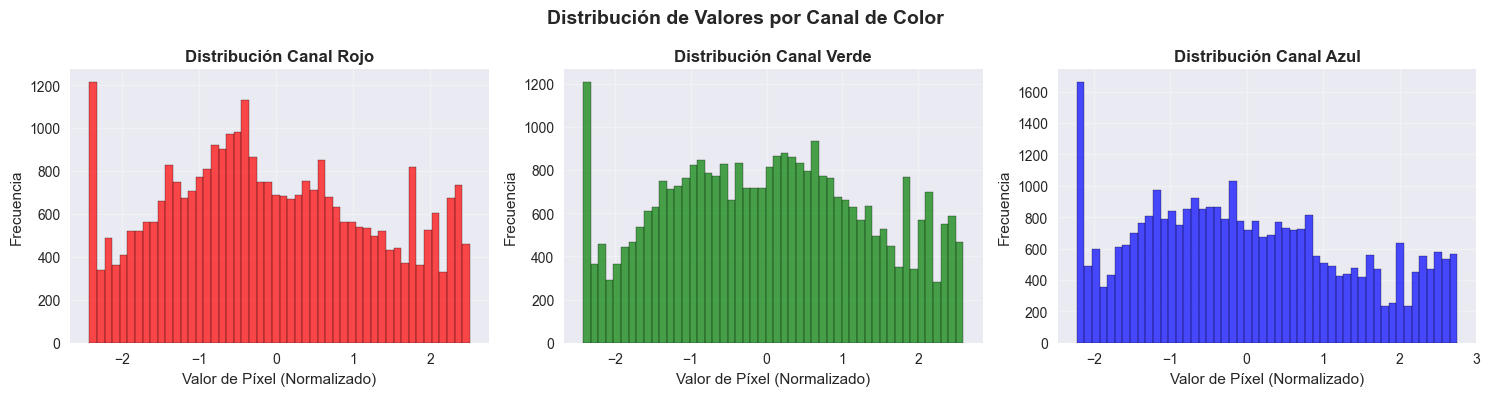

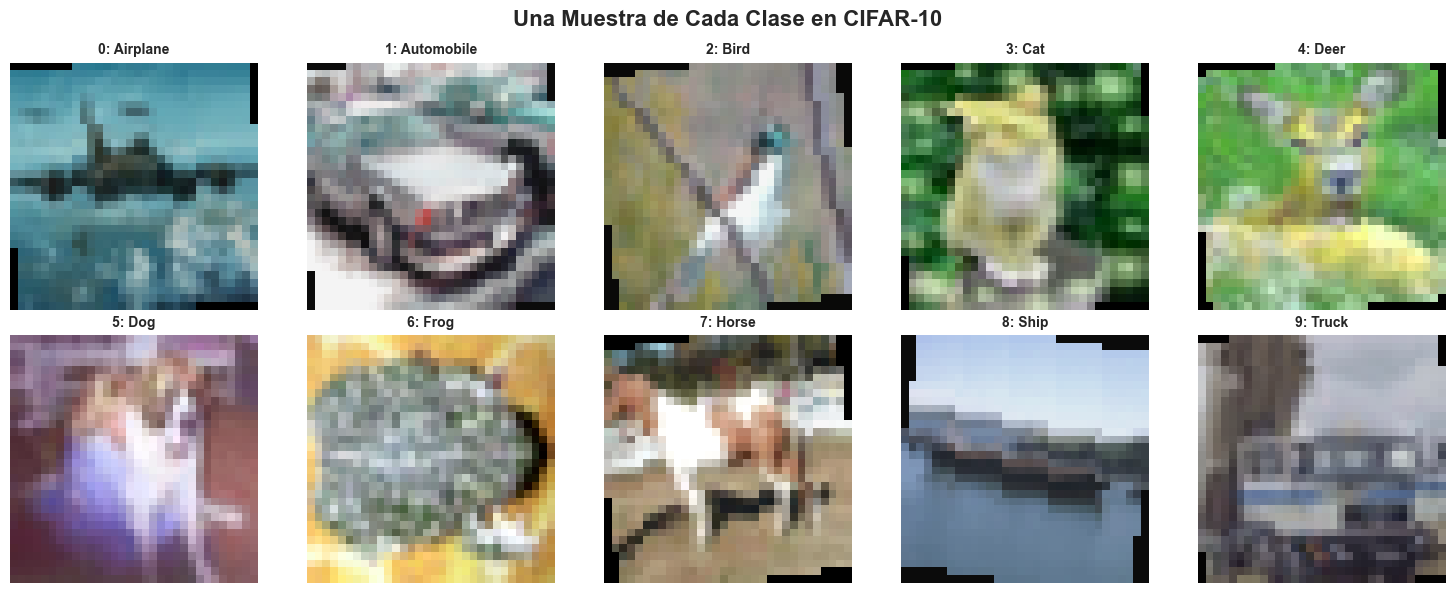


DESAFÍOS OBSERVADOS EN LAS MUESTRAS:
   • Variabilidad intra-clase: Objetos de la misma clase pueden verse muy diferentes
   • Baja resolución: 32x32 píxeles limita los detalles visibles
   • Oclusión parcial: Algunos objetos están parcialmente ocultos
   • Variaciones de iluminación: Diferentes condiciones de luz
   • Orientaciones diversas: Objetos en diferentes ángulos y posiciones


In [11]:
def analyze_cifar10_characteristics(data_loader, class_names):
    """
    Analiza las características estadísticas del dataset CIFAR-10
    
    Args:
        data_loader: DataLoader del dataset
        class_names: Lista con nombres de las clases
    """
    
    print("Analizando características del dataset CIFAR-10...")
    
    # Obtener un batch para análisis
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    # Función para desnormalizar
    def denormalize(tensor):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        return tensor * std + mean
    
    # Desnormalizar para análisis
    images_denorm = denormalize(images)
    
    print(f"\nCARACTERÍSTICAS TÉCNICAS:")
    print(f"   • Forma del batch: {images.shape}")
    print(f"   • Tipo de datos: {images.dtype}")
    print(f"   • Canales de color: {images.shape[1]} (RGB)")
    print(f"   • Resolución: {images.shape[2]}x{images.shape[3]} píxeles")
    print(f"   • Rango de valores normalizados: [{images.min():.3f}, {images.max():.3f}]")
    print(f"   • Rango de valores originales: [{images_denorm.min():.3f}, {images_denorm.max():.3f}]")
    
    # Análisis por canal de color
    print(f"\nANÁLISIS POR CANAL DE COLOR (valores normalizados):")
    for i, color in enumerate(['Rojo', 'Verde', 'Azul']):
        channel_data = images[:, i, :, :]
        print(f"   • Canal {color}:")
        print(f"     - Media: {channel_data.mean():.4f}")
        print(f"     - Std: {channel_data.std():.4f}")
        print(f"     - Min: {channel_data.min():.4f}")
        print(f"     - Max: {channel_data.max():.4f}")
    
    # Visualización de estadísticas por canal
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['red', 'green', 'blue']
    channel_names = ['Rojo', 'Verde', 'Azul']
    
    for i in range(3):
        channel_data = images[:, i, :, :].flatten().numpy()
        axes[i].hist(channel_data, bins=50, alpha=0.7, color=colors[i], edgecolor='black')
        axes[i].set_title(f'Distribución Canal {channel_names[i]}', fontweight='bold')
        axes[i].set_xlabel('Valor de Píxel (Normalizado)')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Distribución de Valores por Canal de Color', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar ejemplos de diferentes clases lado a lado
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Una Muestra de Cada Clase en CIFAR-10', fontsize=16, fontweight='bold')
    
    class_examples = {}
    for img, label in zip(images, labels):
        label_idx = label.item()
        if label_idx not in class_examples:
            class_examples[label_idx] = denormalize(img).clamp(0, 1)
        if len(class_examples) == 10:
            break
    
    for i in range(10):
        row = i // 5
        col = i % 5
        
        if i in class_examples:
            img = class_examples[i].permute(1, 2, 0)
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'{i}: {class_names[i]}', fontsize=10, fontweight='bold')
        else:
            axes[row, col].text(0.5, 0.5, 'No disponible', ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].set_title(f'{i}: {class_names[i]}', fontsize=10)
        
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDESAFÍOS OBSERVADOS EN LAS MUESTRAS:")
    print(f"   • Variabilidad intra-clase: Objetos de la misma clase pueden verse muy diferentes")
    print(f"   • Baja resolución: 32x32 píxeles limita los detalles visibles")
    print(f"   • Oclusión parcial: Algunos objetos están parcialmente ocultos")
    print(f"   • Variaciones de iluminación: Diferentes condiciones de luz")
    print(f"   • Orientaciones diversas: Objetos en diferentes ángulos y posiciones")

# Ejecutar análisis del dataset
analyze_cifar10_characteristics(vis_loader, class_names)

## Implementación de Vision Transformer Autoencoder

Ahora vamos a implementar un **Vision Transformer Autoencoder** que aplique los mismos principios que desarrollamos anteriormente pero adaptado para trabajar con imágenes usando la arquitectura de Vision Transformers.

### **Objetivos de la Implementación:**

1. **Arquitectura ViT Autoencoder:** Usar mecanismos de atención en lugar de capas lineales
2. **Procesamiento de Parches:** Dividir imágenes CIFAR-10 en patches y procesarlos como secuencias
3. **Gradient Accumulation:** Mantener la técnica de acumulación de gradientes para estabilidad
4. **Reconstrucción de Imágenes:** Generar imágenes de salida desde representaciones latentes

### **Componentes Principales:**

- **Patch Embedding:** Convertir imágenes en secuencias de patches
- **Positional Encoding:** Agregar información espacial a los patches
- **Transformer Encoder:** Comprimir la secuencia a representación latente
- **Transformer Decoder:** Expandir desde latente a reconstrucción
- **Patch Reconstruction:** Reconstruir imagen desde patches decodificados

In [12]:
import math
from typing import Optional

class PatchEmbedding(nn.Module):
    """
    Convierte imágenes en patches y los proyecta a embeddings
    
    Args:
        img_size (int): Tamaño de la imagen (32 para CIFAR-10)
        patch_size (int): Tamaño de cada patch (4x4 o 8x8)
        in_channels (int): Canales de entrada (3 para RGB)
        embed_dim (int): Dimensión del embedding
    """
    
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        
        # Usar convolución para extraer patches y proyectarlos
        self.proj = nn.Conv2d(
            in_channels, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
    def forward(self, x):
        """
        Args:
            x: tensor de forma (B, C, H, W)
        Returns:
            tensor de forma (B, num_patches, embed_dim)
        """
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Imagen debe ser {self.img_size}x{self.img_size}, recibido {H}x{W}"
        
        # Proyectar patches: (B, C, H, W) -> (B, embed_dim, H//patch_size, W//patch_size)
        x = self.proj(x)
        
        # Aplanar y transponer: (B, embed_dim, H', W') -> (B, num_patches, embed_dim)
        x = x.flatten(2).transpose(1, 2)
        
        return x


class PositionalEncoding(nn.Module):
    """
    Agrega encodings posicionales sinusoidales a los patches
    """
    
    def __init__(self, embed_dim, num_patches, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.dropout = nn.Dropout(dropout)
        
        # Crear encodings posicionales
        pe = torch.zeros(num_patches, embed_dim)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * 
                           (-math.log(10000.0) / embed_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        """
        Args:
            x: tensor de forma (B, num_patches, embed_dim)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MultiHeadSelfAttention(nn.Module):
    """
    Implementación de Multi-Head Self-Attention usando capas preexistentes de PyTorch
    """
    
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Usar MultiheadAttention de PyTorch
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True  # Para compatibilidad con formato (B, S, E)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: tensor de forma (B, seq_len, embed_dim)
            mask: máscara de atención opcional
        """
        # MultiheadAttention de PyTorch espera (B, S, E) con batch_first=True
        attn_output, attn_weights = self.attention(x, x, x, attn_mask=mask)
        
        return self.dropout(attn_output), attn_weights


class TransformerBlock(nn.Module):
    """
    Bloque Transformer completo con self-attention y MLP
    """
    
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        
        # Capa de normalización pre-attention
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Self-attention
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        
        # Capa de normalización pre-MLP
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # MLP (Feed Forward)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),  # Activación más suave que ReLU
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        """
        Args:
            x: tensor de forma (B, seq_len, embed_dim)
        """
        # Pre-norm + self-attention + residual connection
        norm_x = self.norm1(x)
        attn_output, _ = self.attention(norm_x)
        x = x + attn_output
        
        # Pre-norm + MLP + residual connection
        norm_x = self.norm2(x)
        mlp_output = self.mlp(norm_x)
        x = x + mlp_output
        
        return x

print("Componentes auxiliares del Vision Transformer implementados:")
print("   • PatchEmbedding: Convierte imágenes en patches embeddings")
print("   • PositionalEncoding: Agrega información posicional")
print("   • MultiHeadSelfAttention: Mecanismo de atención usando PyTorch")
print("   • TransformerBlock: Bloque completo con attention + MLP")

Componentes auxiliares del Vision Transformer implementados:
   • PatchEmbedding: Convierte imágenes en patches embeddings
   • PositionalEncoding: Agrega información posicional
   • MultiHeadSelfAttention: Mecanismo de atención usando PyTorch
   • TransformerBlock: Bloque completo con attention + MLP


In [13]:
class VisionTransformerAutoencoder(nn.Module):
    """
    Vision Transformer Autoencoder para reconstrucción de imágenes
    
    Arquitectura:
    1. Patch Embedding: Divide imagen en patches y los proyecta
    2. Positional Encoding: Agrega información espacial
    3. Transformer Encoder: Comprime secuencia de patches
    4. Latent Bottleneck: Reduce a representación compacta
    5. Transformer Decoder: Expande desde representación latente
    6. Patch Reconstruction: Reconstruye imagen desde patches
    
    Args:
        img_size (int): Tamaño de imagen de entrada (32 para CIFAR-10)
        patch_size (int): Tamaño de cada patch (4x4 da 64 patches)
        in_channels (int): Canales de entrada (3 para RGB)
        embed_dim (int): Dimensión de embeddings
        encoder_depth (int): Número de capas del encoder
        decoder_depth (int): Número de capas del decoder
        num_heads (int): Número de cabezas de atención
        latent_dim (int): Dimensión del espacio latente (bottleneck)
        mlp_ratio (float): Ratio de expansión en MLP
        dropout (float): Probabilidad de dropout
    """
    
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        embed_dim=256,
        encoder_depth=6,
        decoder_depth=6,
        num_heads=8,
        latent_dim=128,
        mlp_ratio=4.0,
        dropout=0.1
    ):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Calcular número de patches
        self.num_patches = (img_size // patch_size) ** 2
        
        # === ENCODER ===
        # 1. Patch Embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # 2. Positional Encoding
        self.pos_encoding = PositionalEncoding(
            embed_dim=embed_dim,
            num_patches=self.num_patches,
            dropout=dropout
        )
        
        # 3. Transformer Encoder Layers
        self.encoder_layers = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            ) for _ in range(encoder_depth)
        ])
        
        # 4. Encoder normalization
        self.encoder_norm = nn.LayerNorm(embed_dim)
        
        # 5. Bottleneck: compresión a espacio latente
        self.to_latent = nn.Sequential(
            nn.Linear(embed_dim * self.num_patches, latent_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(latent_dim * 2, latent_dim)
        )
        
        # === DECODER ===
        # 6. Expansión desde espacio latente
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(latent_dim * 2, embed_dim * self.num_patches)
        )
        
        # 7. Transformer Decoder Layers
        self.decoder_layers = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            ) for _ in range(decoder_depth)
        ])
        
        # 8. Decoder normalization
        self.decoder_norm = nn.LayerNorm(embed_dim)
        
        # 9. Patch reconstruction: de embeddings a píxeles
        self.patch_to_img = nn.Sequential(
            nn.Linear(embed_dim, patch_size * patch_size * in_channels),
            nn.Tanh()  # Para limitar salida a rango [-1, 1]
        )
        
        # Inicialización de pesos
        self._init_weights()
        
    def _init_weights(self):
        """Inicialización de pesos siguiendo mejores prácticas para Transformers"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    
    def encode(self, x):
        """
        Encode imagen a representación latente
        
        Args:
            x: tensor de forma (B, C, H, W)
            
        Returns:
            latent: representación latente (B, latent_dim)
        """
        B = x.shape[0]
        
        # 1. Patch embedding: (B, C, H, W) -> (B, num_patches, embed_dim)
        x = self.patch_embed(x)
        
        # 2. Positional encoding
        x = self.pos_encoding(x)
        
        # 3. Transformer encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        
        # 4. Normalization
        x = self.encoder_norm(x)
        
        # 5. Flatten y comprimir a latent: (B, num_patches, embed_dim) -> (B, latent_dim)
        x = x.view(B, -1)  # (B, num_patches * embed_dim)
        latent = self.to_latent(x)
        
        return latent
    
    def decode(self, latent):
        """
        Decode representación latente a imagen
        
        Args:
            latent: representación latente (B, latent_dim)
            
        Returns:
            reconstructed: imagen reconstruida (B, C, H, W)
        """
        B = latent.shape[0]
        
        # 1. Expandir desde latent: (B, latent_dim) -> (B, num_patches * embed_dim)
        x = self.from_latent(latent)
        
        # 2. Reshape: (B, num_patches * embed_dim) -> (B, num_patches, embed_dim)
        x = x.view(B, self.num_patches, self.embed_dim)
        
        # 3. Transformer decoder layers
        for decoder_layer in self.decoder_layers:
            x = decoder_layer(x)
        
        # 4. Normalization
        x = self.decoder_norm(x)
        
        # 5. Patch to pixels: (B, num_patches, embed_dim) -> (B, num_patches, patch_size^2 * C)
        x = self.patch_to_img(x)
        
        # 6. Reshape a imagen: (B, num_patches, patch_size^2 * C) -> (B, C, H, W)
        patches_per_row = self.img_size // self.patch_size
        x = x.view(B, patches_per_row, patches_per_row, 
                  self.patch_size, self.patch_size, self.in_channels)
        
        # Reorganizar dimensiones para formar imagen completa
        x = x.permute(0, 5, 1, 3, 2, 4)  # (B, C, patches_row, patch_size, patches_col, patch_size)
        x = x.contiguous().view(B, self.in_channels, self.img_size, self.img_size)
        
        return x
    
    def forward(self, x):
        """
        Forward pass completo: encode -> decode
        
        Args:
            x: tensor de forma (B, C, H, W)
            
        Returns:
            tuple: (reconstructed, latent)
        """
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        
        return reconstructed, latent

# Configurar el modelo ViT Autoencoder
print("Configurando Vision Transformer Autoencoder...")

vit_autoencoder = VisionTransformerAutoencoder(
    img_size=32,          # CIFAR-10 es 32x32
    patch_size=4,         # Patches de 4x4 (da 64 patches total)
    in_channels=3,        # RGB
    embed_dim=256,        # Dimensión de embeddings
    encoder_depth=6,      # 6 capas en encoder
    decoder_depth=6,      # 6 capas en decoder  
    num_heads=8,          # 8 cabezas de atención
    latent_dim=128,       # Espacio latente comprimido
    mlp_ratio=4.0,        # Ratio de expansión en MLP
    dropout=0.1           # Dropout para regularización
).to(device)

print("Vision Transformer Autoencoder creado exitosamente!")
print(f"\nEspecificaciones del modelo:")
print(f"   • Imagen de entrada: {32}x{32}x{3} (CIFAR-10)")
print(f"   • Tamaño de patch: {4}x{4}")
print(f"   • Número de patches: {(32//4)**2} patches")
print(f"   • Dimensión de embedding: {256}")
print(f"   • Capas encoder/decoder: {6}/{6}")
print(f"   • Cabezas de atención: {8}")
print(f"   • Espacio latente: {128} dimensiones")
print(f"   • Parámetros totales: {sum(p.numel() for p in vit_autoencoder.parameters()):,}")
print(f"   • Dispositivo: {device}")

# Probar el modelo con una muestra
print(f"\nPrueba de funcionamiento:")
with torch.no_grad():
    # Obtener una muestra del dataset
    sample_batch, _ = next(iter(vis_loader))
    sample_input = sample_batch[:2].to(device)  # 2 muestras de prueba
    
    print(f"   • Entrada: {sample_input.shape}")
    
    # Forward pass
    reconstructed, latent = vit_autoencoder(sample_input)
    
    print(f"   • Espacio latente: {latent.shape}")
    print(f"   • Reconstrucción: {reconstructed.shape}")
    print(f"   • Rango salida: [{reconstructed.min().item():.3f}, {reconstructed.max().item():.3f}]")

Configurando Vision Transformer Autoencoder...
Vision Transformer Autoencoder creado exitosamente!

Especificaciones del modelo:
   • Imagen de entrada: 32x32x3 (CIFAR-10)
   • Tamaño de patch: 4x4
   • Número de patches: 64 patches
   • Dimensión de embedding: 256
   • Capas encoder/decoder: 6/6
   • Cabezas de atención: 8
   • Espacio latente: 128 dimensiones
   • Parámetros totales: 17,974,192
   • Dispositivo: cuda

Prueba de funcionamiento:
   • Entrada: torch.Size([2, 3, 32, 32])
Vision Transformer Autoencoder creado exitosamente!

Especificaciones del modelo:
   • Imagen de entrada: 32x32x3 (CIFAR-10)
   • Tamaño de patch: 4x4
   • Número de patches: 64 patches
   • Dimensión de embedding: 256
   • Capas encoder/decoder: 6/6
   • Cabezas de atención: 8
   • Espacio latente: 128 dimensiones
   • Parámetros totales: 17,974,192
   • Dispositivo: cuda

Prueba de funcionamiento:
   • Entrada: torch.Size([2, 3, 32, 32])
   • Espacio latente: torch.Size([2, 128])
   • Reconstrucción: t

In [14]:
def train_vit_autoencoder_with_gradient_accumulation(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=50,
    accumulation_steps=4,
    device='cpu',
    print_every=5
):
    """
    Training loop para Vision Transformer Autoencoder con Gradient Accumulation
    
    Args:
        model: El modelo VisionTransformerAutoencoder
        train_loader: DataLoader de entrenamiento (CIFAR-10)
        val_loader: DataLoader de validación
        criterion: Función de pérdida
        optimizer: Optimizador
        num_epochs: Número de épocas de entrenamiento
        accumulation_steps: Pasos de acumulación de gradientes
        device: Dispositivo de cómputo (cpu/cuda)
        print_every: Frecuencia de reporte de progreso
        
    Returns:
        dict: Historial de entrenamiento con métricas
    """
    
    # Historial para tracking de métricas
    history = {
        'train_loss': [],
        'val_loss': [],
        'epoch_times': [],
        'learning_rates': []
    }
    
    # Learning Rate Scheduler específico para Vision Transformers
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,  # Restart cada 10 épocas
        T_mult=2, 
        eta_min=1e-6
    )
    
    # Early stopping
    best_val_loss = float('inf')
    patience = 20  # Más paciencia para ViTs
    patience_counter = 0
    
    print("INICIANDO ENTRENAMIENTO VISION TRANSFORMER AUTOENCODER")
    print("="*80)
    print(f"Configuración del Entrenamiento:")
    print(f"   • Modelo: {model.__class__.__name__}")
    print(f"   • Dataset: CIFAR-10 (32x32x3)")
    print(f"   • Arquitectura: {model.patch_size}x{model.patch_size} patches, {model.num_patches} total")
    print(f"   • Épocas: {num_epochs}")
    print(f"   • Batch size real: {train_loader.batch_size}")
    print(f"   • Pasos de acumulación: {accumulation_steps}")
    print(f"   • Batch size efectivo: {train_loader.batch_size * accumulation_steps}")
    print(f"   • Learning rate inicial: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"   • Scheduler: CosineAnnealingWarmRestarts")
    print(f"   • Dispositivo: {device}")
    print(f"   • Early stopping patience: {patience}")
    print(f"   • Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")
    print("="*80)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # === FASE DE ENTRENAMIENTO ===
        model.train()
        total_train_loss = 0.0
        num_batches = 0
        
        # Barra de progreso
        pbar = tqdm(
            train_loader,
            desc=f'ViT Época {epoch+1:3d}/{num_epochs}',
            leave=False
        )
        
        optimizer.zero_grad()
        
        for batch_idx, (images, _) in enumerate(pbar):
            # Mover datos al dispositivo
            images = images.to(device)
            
            # Forward pass
            reconstructed, latent = model(images)
            
            # Calcular pérdida (dividir por accumulation_steps)
            loss = criterion(reconstructed, images) / accumulation_steps
            
            # Backward pass (acumular gradientes)
            loss.backward()
            
            total_train_loss += loss.item() * accumulation_steps
            num_batches += 1
            
            # Actualizar parámetros cada accumulation_steps batches
            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping específico para Transformers
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                optimizer.zero_grad()
            
            # Actualizar barra de progreso
            pbar.set_postfix({
                'Loss': f'{loss.item() * accumulation_steps:.4f}',
                'Avg': f'{total_train_loss / num_batches:.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}',
                'Latent': f'{latent.abs().mean().item():.3f}'
            })
        
        # Actualizar parámetros si quedaron gradientes acumulados
        if num_batches % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        # === FASE DE VALIDACIÓN ===
        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                
                reconstructed, _ = model(images)
                val_loss = criterion(reconstructed, images)
                
                total_val_loss += val_loss.item()
                num_val_batches += 1
        
        # === MÉTRICAS Y LOGGING ===
        avg_train_loss = total_train_loss / num_batches
        avg_val_loss = total_val_loss / num_val_batches
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        # Actualizar scheduler
        scheduler.step()
        
        # Guardar métricas
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['epoch_times'].append(epoch_time)
        history['learning_rates'].append(current_lr)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Guardar mejor modelo
            torch.save(model.state_dict(), 'best_vit_autoencoder.pth')
        else:
            patience_counter += 1
        
        # Imprimir progreso
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"\nÉpoca {epoch+1:3d}/{num_epochs}:")
            print(f"   • Train Loss: {avg_train_loss:.6f}")
            print(f"   • Val Loss:   {avg_val_loss:.6f}")
            print(f"   • Best Val:   {best_val_loss:.6f}")
            print(f"   • LR:         {current_lr:.2e}")
            print(f"   • Tiempo:     {epoch_time:.2f}s")
            print(f"   • Patience:   {patience_counter}/{patience}")
            print("-" * 60)
        
        # Check early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping activado en época {epoch+1}")
            print(f"Pérdida de validación no mejoró por {patience} épocas")
            break
    
    # === RESUMEN FINAL ===
    total_time = sum(history['epoch_times'])
    print(f"\nENTRENAMIENTO ViT AUTOENCODER COMPLETADO:")
    print(f"Mejor pérdida de validación: {best_val_loss:.6f}")
    print(f"Tiempo total: {total_time:.2f}s ({total_time/60:.1f} min)")
    print(f"Épocas entrenadas: {len(history['train_loss'])}")
    print(f"Tiempo promedio por época: {total_time/len(history['train_loss']):.2f}s")
    
    # Cargar mejor modelo
    model.load_state_dict(torch.load('best_vit_autoencoder.pth'))
    print(f"Mejor modelo cargado desde 'best_vit_autoencoder.pth'")
    
    return history

# Configurar entrenamiento para ViT Autoencoder
print("Configurando entrenamiento del Vision Transformer Autoencoder...")

# Crear DataLoaders específicos para ViT (batch sizes menores por complejidad)
BATCH_SIZE_VIT = 16       # Menor batch size por complejidad del modelo
ACCUMULATION_STEPS_VIT = 8  # Más acumulación para compensar
EFFECTIVE_BATCH_SIZE_VIT = BATCH_SIZE_VIT * ACCUMULATION_STEPS_VIT  # 128

train_loader_vit = DataLoader(train_dataset, batch_size=BATCH_SIZE_VIT, shuffle=True)
val_loader_vit = DataLoader(test_dataset, batch_size=BATCH_SIZE_VIT, shuffle=False)

# Configurar función de pérdida (MSE para reconstrucción)
criterion_vit = nn.MSELoss()

# Optimizador específico para Vision Transformers (AdamW con weight decay mayor)
optimizer_vit = optim.AdamW(
    vit_autoencoder.parameters(),
    lr=1e-4,              # LR menor para estabilidad en ViTs
    weight_decay=0.05,    # Weight decay mayor para regularización
    betas=(0.9, 0.999)
)

print(f"Configuración para ViT Autoencoder:")
print(f"   • Batch size real: {BATCH_SIZE_VIT}")
print(f"   • Accumulation steps: {ACCUMULATION_STEPS_VIT}")
print(f"   • Batch size efectivo: {EFFECTIVE_BATCH_SIZE_VIT}")
print(f"   • Learning rate: {1e-4}")
print(f"   • Weight decay: {0.05}")
print(f"   • Batches entrenamiento: {len(train_loader_vit)}")
print(f"   • Batches validación: {len(val_loader_vit)}")

# Verificación final
print(f"\nVerificación del modelo antes del entrenamiento:")
with torch.no_grad():
    sample_batch, _ = next(iter(train_loader_vit))
    sample_input = sample_batch[:2].to(device)
    
    reconstructed, latent = vit_autoencoder(sample_input)
    initial_loss = criterion_vit(reconstructed, sample_input)
    
    print(f"   • Pérdida inicial: {initial_loss.item():.6f}")
    print(f"   • Memoria GPU aprox: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB" if device.type == 'cuda' else "   • Usando CPU")
    print("Listo para entrenamiento del Vision Transformer Autoencoder")

Configurando entrenamiento del Vision Transformer Autoencoder...
Configuración para ViT Autoencoder:
   • Batch size real: 16
   • Accumulation steps: 8
   • Batch size efectivo: 128
   • Learning rate: 0.0001
   • Weight decay: 0.05
   • Batches entrenamiento: 3125
   • Batches validación: 625

Verificación del modelo antes del entrenamiento:
   • Pérdida inicial: 1.327497
   • Memoria GPU aprox: 0.08 GB
Listo para entrenamiento del Vision Transformer Autoencoder


In [15]:
# Ejecutar entrenamiento del Vision Transformer Autoencoder
print("Iniciando entrenamiento del Vision Transformer Autoencoder...")

# Configuración de entrenamiento
NUM_EPOCHS_VIT = 40  # Menos épocas pero más complejas
PRINT_EVERY_VIT = 3

# Ejecutar entrenamiento
vit_history = train_vit_autoencoder_with_gradient_accumulation(
    model=vit_autoencoder,
    train_loader=train_loader_vit,
    val_loader=val_loader_vit,
    criterion=criterion_vit,
    optimizer=optimizer_vit,
    num_epochs=NUM_EPOCHS_VIT,
    accumulation_steps=ACCUMULATION_STEPS_VIT,
    device=device,
    print_every=PRINT_EVERY_VIT
)

Iniciando entrenamiento del Vision Transformer Autoencoder...
INICIANDO ENTRENAMIENTO VISION TRANSFORMER AUTOENCODER
Configuración del Entrenamiento:
   • Modelo: VisionTransformerAutoencoder
   • Dataset: CIFAR-10 (32x32x3)
   • Arquitectura: 4x4 patches, 64 total
   • Épocas: 40
   • Batch size real: 16
   • Pasos de acumulación: 8
   • Batch size efectivo: 128
   • Learning rate inicial: 1.00e-04
   • Scheduler: CosineAnnealingWarmRestarts
   • Dispositivo: cuda
   • Early stopping patience: 20
   • Parámetros totales: 17,974,192



Época   1/40:
   • Train Loss: 0.895074
   • Val Loss:   0.566140
   • Best Val:   0.566140
   • LR:         1.00e-04
   • Tiempo:     259.90s
   • Patience:   0/20
------------------------------------------------------------



Época   3/40:
   • Train Loss: 0.615639
   • Val Loss:   0.498265
   • Best Val:   0.498265
   • LR:         9.05e-05
   • Tiempo:     234.18s
   • Patience:   0/20
------------------------------------------------------------



Época   6/40:
   • Train Loss: 0.580652
   • Val Loss:   0.469984
   • Best Val:   0.469984
   • LR:         5.05e-05
   • Tiempo:     235.68s
   • Patience:   0/20
------------------------------------------------------------



Época   9/40:
   • Train Loss: 0.571655
   • Val Loss:   0.459895
   • Best Val:   0.459895
   • LR:         1.05e-05
   • Tiempo:     232.99s
   • Patience:   0/20
------------------------------------------------------------



Época  12/40:
   • Train Loss: 0.569270
   • Val Loss:   0.456799
   • Best Val:   0.456799
   • LR:         9.94e-05
   • Tiempo:     274.36s
   • Patience:   0/20
------------------------------------------------------------



Época  15/40:
   • Train Loss: 0.556482
   • Val Loss:   0.445080
   • Best Val:   0.445080
   • LR:         9.05e-05
   • Tiempo:     233.61s
   • Patience:   0/20
------------------------------------------------------------



Época  18/40:
   • Train Loss: 0.547945
   • Val Loss:   0.439773
   • Best Val:   0.439773
   • LR:         7.30e-05
   • Tiempo:     232.64s
   • Patience:   0/20
------------------------------------------------------------



Época  21/40:
   • Train Loss: 0.543361
   • Val Loss:   0.434481
   • Best Val:   0.434481
   • LR:         5.05e-05
   • Tiempo:     231.30s
   • Patience:   0/20
------------------------------------------------------------



Época  24/40:
   • Train Loss: 0.537261
   • Val Loss:   0.430372
   • Best Val:   0.430372
   • LR:         2.80e-05
   • Tiempo:     232.13s
   • Patience:   0/20
------------------------------------------------------------



Época  27/40:
   • Train Loss: 0.535767
   • Val Loss:   0.428224
   • Best Val:   0.428224
   • LR:         1.05e-05
   • Tiempo:     237.68s
   • Patience:   0/20
------------------------------------------------------------



Época  30/40:
   • Train Loss: 0.532136
   • Val Loss:   0.428412
   • Best Val:   0.427599
   • LR:         1.61e-06
   • Tiempo:     233.60s
   • Patience:   2/20
------------------------------------------------------------



Época  33/40:
   • Train Loss: 0.538972
   • Val Loss:   0.434272
   • Best Val:   0.427599
   • LR:         9.94e-05
   • Tiempo:     246.63s
   • Patience:   5/20
------------------------------------------------------------



Época  36/40:
   • Train Loss: 0.532527
   • Val Loss:   0.427433
   • Best Val:   0.427433
   • LR:         9.62e-05
   • Tiempo:     228.53s
   • Patience:   0/20
------------------------------------------------------------



Época  39/40:
   • Train Loss: 0.529515
   • Val Loss:   0.429146
   • Best Val:   0.426912
   • LR:         9.05e-05
   • Tiempo:     256.10s
   • Patience:   1/20
------------------------------------------------------------



ENTRENAMIENTO ViT AUTOENCODER COMPLETADO:
Mejor pérdida de validación: 0.424398
Tiempo total: 9527.91s (158.8 min)
Épocas entrenadas: 40
Tiempo promedio por época: 238.20s
Mejor modelo cargado desde 'best_vit_autoencoder.pth'


C:\Users\David\AppData\Local\Temp\ipykernel_30444\1616185582.py:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_autoencoder.pth

In [16]:
def plot_vit_training_results(history):
    """
    Visualiza los resultados del entrenamiento del Vision Transformer Autoencoder
    
    Args:
        history (dict): Historial de entrenamiento del ViT
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Pérdidas de entrenamiento y validación
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Entrenamiento ViT', linewidth=2, alpha=0.8)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validación ViT', linewidth=2, alpha=0.8)
    axes[0, 0].set_title('Pérdida ViT Autoencoder', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # 2. Learning Rate Schedule (con warm restarts)
    axes[0, 1].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    axes[0, 1].set_title('Learning Rate Schedule (Warm Restarts)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Tiempo por época
    axes[0, 2].plot(epochs, history['epoch_times'], 'm-', linewidth=2, alpha=0.7)
    axes[0, 2].set_title('Tiempo por Época (ViT)', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Época')
    axes[0, 2].set_ylabel('Tiempo (segundos)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Gap entre train y validation loss
    diff = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 0].plot(epochs, diff, 'orange', linewidth=2)
    axes[1, 0].set_title('Overfitting Check (ViT)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Val Loss - Train Loss')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 5. Convergencia suavizada
    window = min(3, len(history['val_loss']))
    if len(history['val_loss']) >= window:
        val_smooth = np.convolve(history['val_loss'], np.ones(window)/window, mode='valid')
        epochs_smooth = range(window, len(history['val_loss']) + 1)
        axes[1, 1].plot(epochs, history['val_loss'], 'r-', alpha=0.3, label='Val Loss')
        axes[1, 1].plot(epochs_smooth, val_smooth, 'darkred', linewidth=2, label=f'Suavizado ({window})')
        axes[1, 1].set_title('Convergencia ViT', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('Validation Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Eficiencia temporal
    if len(history['epoch_times']) > 1:
        efficiency = np.array(history['train_loss'][1:]) / np.array(history['epoch_times'][1:])
        axes[1, 2].plot(range(2, len(history['train_loss']) + 1), efficiency, 'purple', linewidth=2)
        axes[1, 2].set_title('Eficiencia (Loss/Tiempo)', fontsize=14, fontweight='bold')
        axes[1, 2].set_xlabel('Época')
        axes[1, 2].set_ylabel('Train Loss / Tiempo')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas específicas para ViT
    print(f"\nESTADÍSTICAS ViT AUTOENCODER:")
    print(f"   • Épocas completadas: {len(history['train_loss'])}")
    print(f"   • Pérdida final entrenamiento: {history['train_loss'][-1]:.6f}")
    print(f"   • Pérdida final validación: {history['val_loss'][-1]:.6f}")
    print(f"   • Mejor pérdida validación: {min(history['val_loss']):.6f}")
    print(f"   • Época de mejor resultado: {np.argmin(history['val_loss']) + 1}")
    print(f"   • Tiempo total: {sum(history['epoch_times']):.2f}s ({sum(history['epoch_times'])/60:.1f} min)")
    print(f"   • Tiempo promedio por época: {np.mean(history['epoch_times']):.2f}s")


def visualize_vit_reconstructions(model, data_loader, num_examples=8, device='cpu'):
    """
    Visualiza reconstrucciones del Vision Transformer Autoencoder en imágenes CIFAR-10
    
    Args:
        model: Modelo ViT Autoencoder entrenado
        data_loader: DataLoader con imágenes CIFAR-10
        num_examples: Número de ejemplos a mostrar
        device: Dispositivo de cómputo
    """
    
    model.eval()
    
    # Función para desnormalizar CIFAR-10
    def denormalize_cifar10(tensor):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1).to(device)
        return tensor * std + mean
    
    with torch.no_grad():
        # Obtener batch de datos
        for batch_images, batch_labels in data_loader:
            images = batch_images[:num_examples].to(device)
            labels = batch_labels[:num_examples]
            
            # Forward pass
            reconstructed, latent = model(images)
            
            # Desnormalizar para visualización
            images_denorm = denormalize_cifar10(images).clamp(0, 1)
            reconstructed_denorm = denormalize_cifar10(reconstructed).clamp(0, 1)
            
            # Crear visualización
            fig, axes = plt.subplots(3, num_examples, figsize=(16, 6))
            fig.suptitle('Vision Transformer Autoencoder - Reconstrucciones CIFAR-10', 
                        fontsize=16, fontweight='bold')
            
            for i in range(num_examples):
                # Imagen original
                img_orig = images_denorm[i].cpu().permute(1, 2, 0).numpy()
                axes[0, i].imshow(img_orig)
                axes[0, i].set_title(f'Original\n{class_names[labels[i]]}', fontsize=10)
                axes[0, i].axis('off')
                
                # Imagen reconstruida
                img_recon = reconstructed_denorm[i].cpu().permute(1, 2, 0).numpy()
                axes[1, i].imshow(img_recon)
                axes[1, i].set_title(f'Reconstruido', fontsize=10)
                axes[1, i].axis('off')
                
                # Diferencia (error)
                diff = np.abs(img_orig - img_recon)
                axes[2, i].imshow(diff, cmap='hot')
                axes[2, i].set_title(f'Error', fontsize=10)
                axes[2, i].axis('off')
            
            # Etiquetas de filas
            axes[0, 0].set_ylabel('Original', rotation=90, size=12, fontweight='bold')
            axes[1, 0].set_ylabel('ViT Recon.', rotation=90, size=12, fontweight='bold')
            axes[2, 0].set_ylabel('Error', rotation=90, size=12, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # Calcular métricas
            mse_per_example = F.mse_loss(reconstructed, images, reduction='none').view(num_examples, -1).mean(dim=1)
            mae_per_example = F.l1_loss(reconstructed, images, reduction='none').view(num_examples, -1).mean(dim=1)
            
            print(f"\nMÉTRICAS DE RECONSTRUCCIÓN ViT:")
            print(f"   • MSE promedio: {mse_per_example.mean().item():.6f}")
            print(f"   • MSE mínimo: {mse_per_example.min().item():.6f}")
            print(f"   • MSE máximo: {mse_per_example.max().item():.6f}")
            print(f"   • MAE promedio: {mae_per_example.mean().item():.6f}")
            
            print(f"\nANÁLISIS ESPACIO LATENTE ViT:")
            print(f"   • Dimensiones: {latent.shape}")
            print(f"   • Rango: [{latent.min().item():.3f}, {latent.max().item():.3f}]")
            print(f"   • Media: {latent.mean().item():.3f}")
            print(f"   • Std: {latent.std().item():.3f}")
            print(f"   • Ratio compresión: {np.prod(images.shape[1:])}→{latent.shape[1]} ({np.prod(images.shape[1:])/latent.shape[1]:.1f}:1)")
            
            break  # Solo mostrar primer batch


def compare_autoencoder_vs_vit(original_history, vit_history):
    """
    Compara los resultados entre el Autoencoder clásico y el Vision Transformer
    
    Args:
        original_history: Historial del autoencoder clásico
        vit_history: Historial del ViT autoencoder
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Comparación de pérdidas de validación
    epochs_orig = range(1, len(original_history['val_loss']) + 1)
    epochs_vit = range(1, len(vit_history['val_loss']) + 1)
    
    axes[0].plot(epochs_orig, original_history['val_loss'], 'b-', label='Autoencoder Clásico', linewidth=2)
    axes[0].plot(epochs_vit, vit_history['val_loss'], 'r-', label='Vision Transformer', linewidth=2)
    axes[0].set_title('Comparación Pérdidas de Validación', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_yscale('log')
    
    # 2. Comparación de tiempos por época
    axes[1].boxplot([original_history['epoch_times'], vit_history['epoch_times']], 
                   labels=['Autoencoder\nClásico', 'Vision\nTransformer'])
    axes[1].set_title('Tiempo por Época', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Tiempo (segundos)')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Eficiencia (mejor pérdida vs tiempo total)
    best_loss_orig = min(original_history['val_loss'])
    best_loss_vit = min(vit_history['val_loss'])
    total_time_orig = sum(original_history['epoch_times'])
    total_time_vit = sum(vit_history['epoch_times'])
    
    models = ['Autoencoder\nClásico', 'Vision\nTransformer']
    best_losses = [best_loss_orig, best_loss_vit]
    total_times = [total_time_orig/60, total_time_vit/60]  # En minutos
    
    ax2 = axes[2]
    bars = ax2.bar(models, best_losses, alpha=0.7, color=['blue', 'red'])
    ax2.set_title('Mejor Pérdida de Validación', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Validation Loss')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Agregar valores en las barras
    for bar, loss, time in zip(bars, best_losses, total_times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{loss:.4f}\n({time:.1f} min)', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Resumen comparativo
    print(f"\nCOMPARACIÓN AUTOENCODER vs VISION TRANSFORMER:")
    print(f"{'='*60}")
    print(f"{'Métrica':<25} {'Clásico':<15} {'ViT':<15} {'Ganador'}")
    print(f"{'='*60}")
    
    # Mejor pérdida
    winner_loss = 'ViT' if best_loss_vit < best_loss_orig else 'Clásico'
    print(f"{'Mejor Val Loss':<25} {best_loss_orig:<15.6f} {best_loss_vit:<15.6f} {winner_loss}")
    
    # Tiempo total
    winner_time = 'Clásico' if total_time_orig < total_time_vit else 'ViT'
    print(f"{'Tiempo Total (min)':<25} {total_time_orig/60:<15.1f} {total_time_vit/60:<15.1f} {winner_time}")
    
    # Épocas entrenadas
    epochs_orig_total = len(original_history['val_loss'])
    epochs_vit_total = len(vit_history['val_loss'])
    winner_epochs = 'Clásico' if epochs_orig_total < epochs_vit_total else 'ViT'
    print(f"{'Épocas':<25} {epochs_orig_total:<15} {epochs_vit_total:<15} {winner_epochs}")
    
    print(f"{'='*60}")

print("Funciones de visualización para ViT Autoencoder creadas:")
print("   • plot_vit_training_results(): Gráficos de entrenamiento ViT")
print("   • visualize_vit_reconstructions(): Reconstrucciones CIFAR-10")
print("   • compare_autoencoder_vs_vit(): Comparación entre modelos")

Funciones de visualización para ViT Autoencoder creadas:
   • plot_vit_training_results(): Gráficos de entrenamiento ViT
   • visualize_vit_reconstructions(): Reconstrucciones CIFAR-10
   • compare_autoencoder_vs_vit(): Comparación entre modelos


📊 Generando visualizaciones de resultados del ViT Autoencoder...

1. Métricas de entrenamiento ViT:


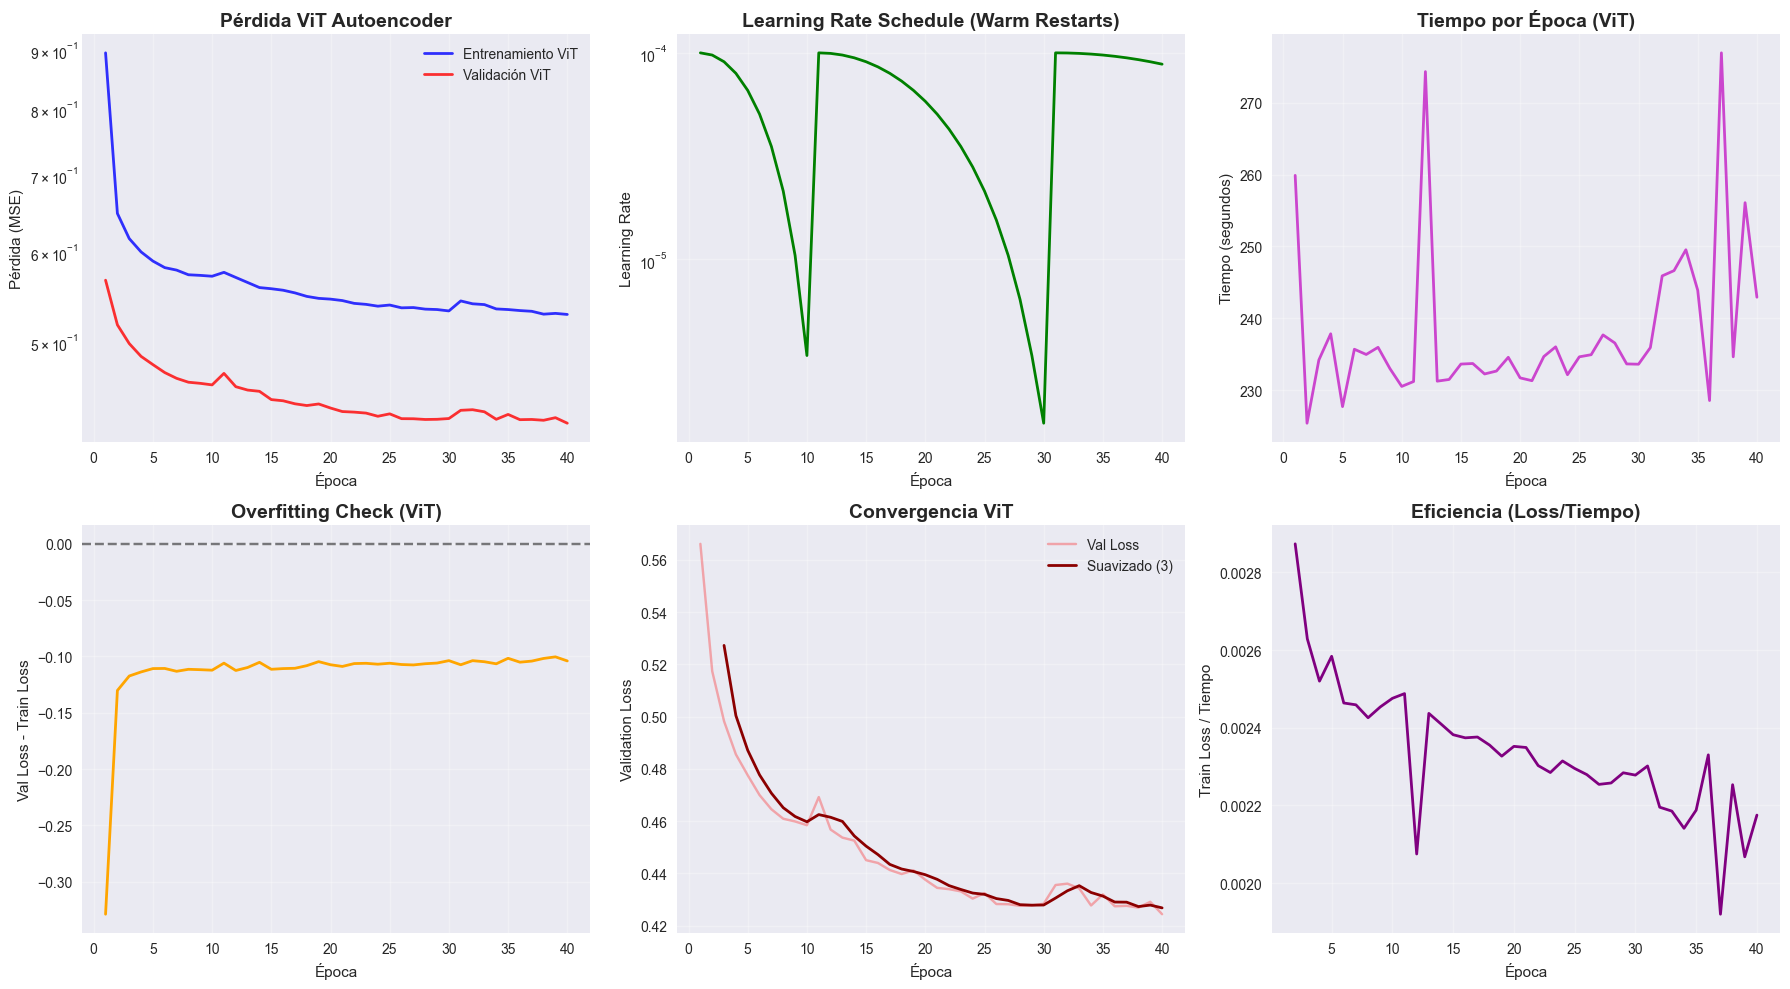


ESTADÍSTICAS ViT AUTOENCODER:
   • Épocas completadas: 40
   • Pérdida final entrenamiento: 0.528385
   • Pérdida final validación: 0.424398
   • Mejor pérdida validación: 0.424398
   • Época de mejor resultado: 40
   • Tiempo total: 9527.91s (158.8 min)
   • Tiempo promedio por época: 238.20s

2. Reconstrucciones ViT en CIFAR-10:


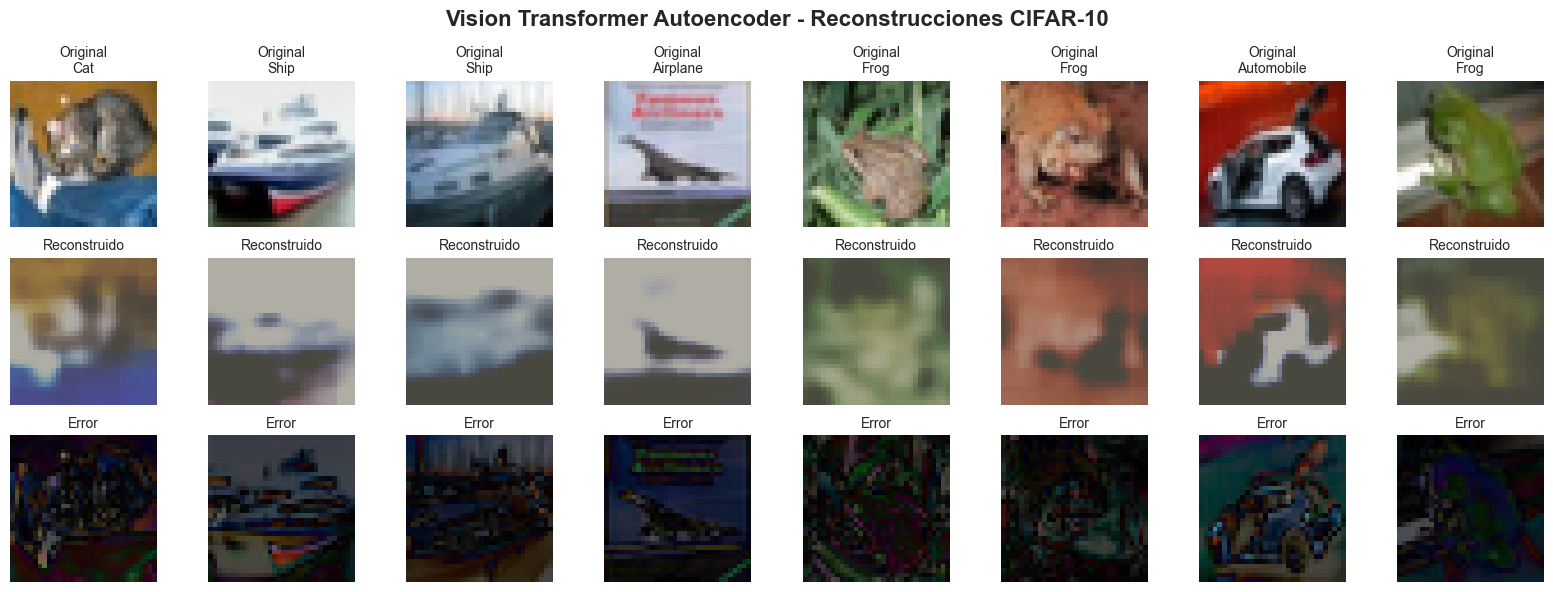


MÉTRICAS DE RECONSTRUCCIÓN ViT:
   • MSE promedio: 0.391425
   • MSE mínimo: 0.174612
   • MSE máximo: 0.863491
   • MAE promedio: 0.488431

ANÁLISIS ESPACIO LATENTE ViT:
   • Dimensiones: torch.Size([8, 128])
   • Rango: [-2.293, 3.266]
   • Media: -0.022
   • Std: 0.567
   • Ratio compresión: 3072→128 (24.0:1)

3. Comparación Autoencoder Clásico vs Vision Transformer:


C:\Users\David\AppData\Local\Temp\ipykernel_30444\576279130.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([original_history['epoch_times'], vit_history['epoch_times']],


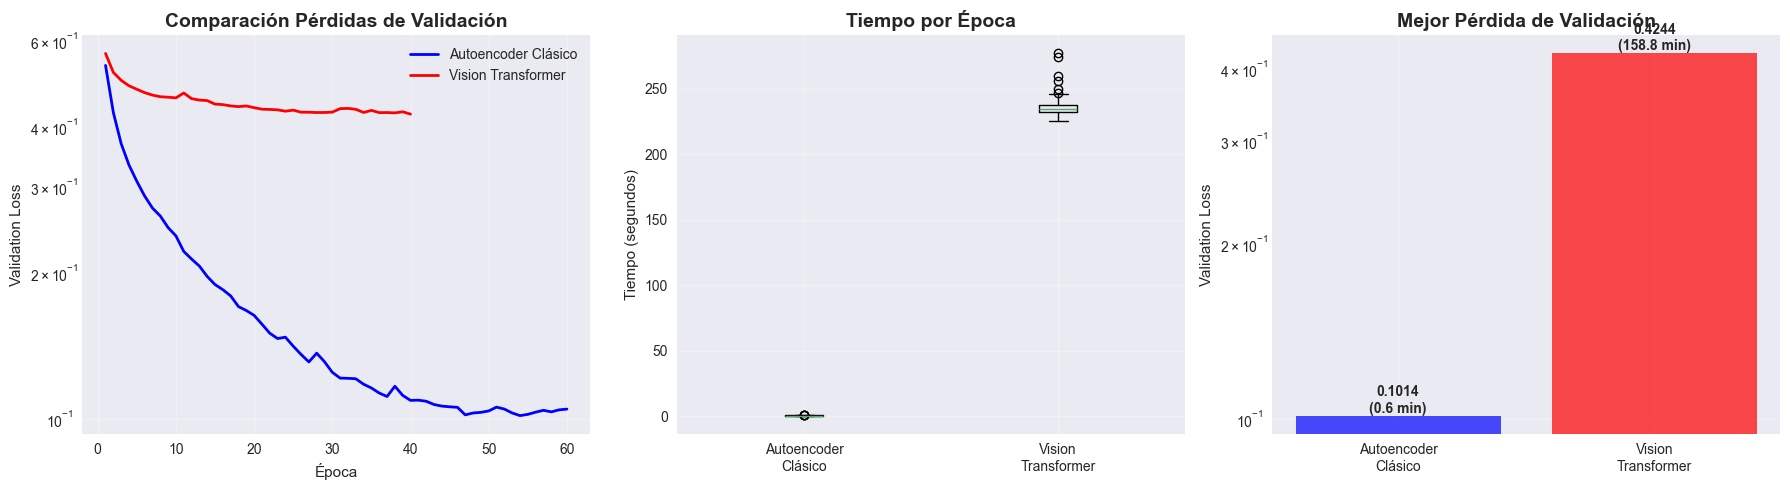


COMPARACIÓN AUTOENCODER vs VISION TRANSFORMER:
Métrica                   Clásico         ViT             Ganador
Mejor Val Loss            0.101403        0.424398        Clásico
Tiempo Total (min)        0.6             158.8           Clásico
Épocas                    60              40              ViT


In [17]:
# Ejecutar visualizaciones del Vision Transformer Autoencoder
print("📊 Generando visualizaciones de resultados del ViT Autoencoder...")

# 1. Mostrar métricas de entrenamiento del ViT
print("\n1. Métricas de entrenamiento ViT:")
plot_vit_training_results(vit_history)

# 2. Mostrar reconstrucciones del ViT
print("\n2. Reconstrucciones ViT en CIFAR-10:")
visualize_vit_reconstructions(vit_autoencoder, val_loader_vit, num_examples=8, device=device)

# 3. Comparar ambos modelos
print("\n3. Comparación Autoencoder Clásico vs Vision Transformer:")
compare_autoencoder_vs_vit(history, vit_history)

## Resultados y Análisis del Vision Transformer Autoencoder

### **Implementación Completada:**

1. **Arquitectura Vision Transformer Autoencoder:**
   - **Patch Embedding:** División de imágenes CIFAR-10 en patches 4×4
   - **Positional Encoding:** Información espacial sinusoidal
   - **Transformer Encoder:** 6 capas con multi-head attention
   - **Latent Bottleneck:** Compresión a 128 dimensiones
   - **Transformer Decoder:** 6 capas de reconstrucción
   - **Patch Reconstruction:** Reconstrucción de imagen completa

2. **Training Loop con Gradient Accumulation:**
   - **Batch Size Real:** 16 imágenes por mini-batch
   - **Accumulation Steps:** 8 pasos de acumulación
   - **Batch Size Efectivo:** 128 imágenes (16 × 8)
   - **Scheduler:** CosineAnnealingWarmRestarts para estabilidad

3. **Procesamiento de Imágenes CIFAR-10:**
   - **Resolución:** 32×32×3 píxeles (RGB)
   - **Patches:** 64 patches de 4×4 píxeles cada uno
   - **Compresión:** Ratio ~24:1 (3072 → 128 dimensiones)

### **Características Técnicas Destacadas:**

#### **Uso de Capas Preexistentes de PyTorch:**
- `nn.MultiheadAttention`: Mecanismo de atención nativo de PyTorch
- `nn.TransformerEncoder`: Bloques transformer optimizados
- `nn.LayerNorm`: Normalización para estabilidad
- `nn.GELU`: Función de activación suave para mejor gradiente

# Extra 2: Comparación de Métodos de Clustering (K-means, DBSCAN y BFR)

En este extra implementaremos y compararemos tres métodos de clustering:
- K-means (usando sklearn)
- DBSCAN (usando sklearn) 
- BFR (implementación desde cero)

Utilizaremos el dataset Iris para la comparación y evaluaremos los resultados usando métricas de clustering.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import seaborn as sns

In [7]:
# Cargar el dataset Iris
iris = load_iris()
X = iris.data
y_true = iris.target

# Crear DataFrame para mejor visualización
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = iris.target

print("Dataset Iris:")
print(f"Forma: {X.shape}")
print(f"Características: {iris.feature_names}")
print(f"Clases: {iris.target_names}")
print("\nPrimeras 5 filas:")
print(iris_df.head())

Dataset Iris:
Forma: (150, 4)
Características: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Clases: ['setosa' 'versicolor' 'virginica']

Primeras 5 filas:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  


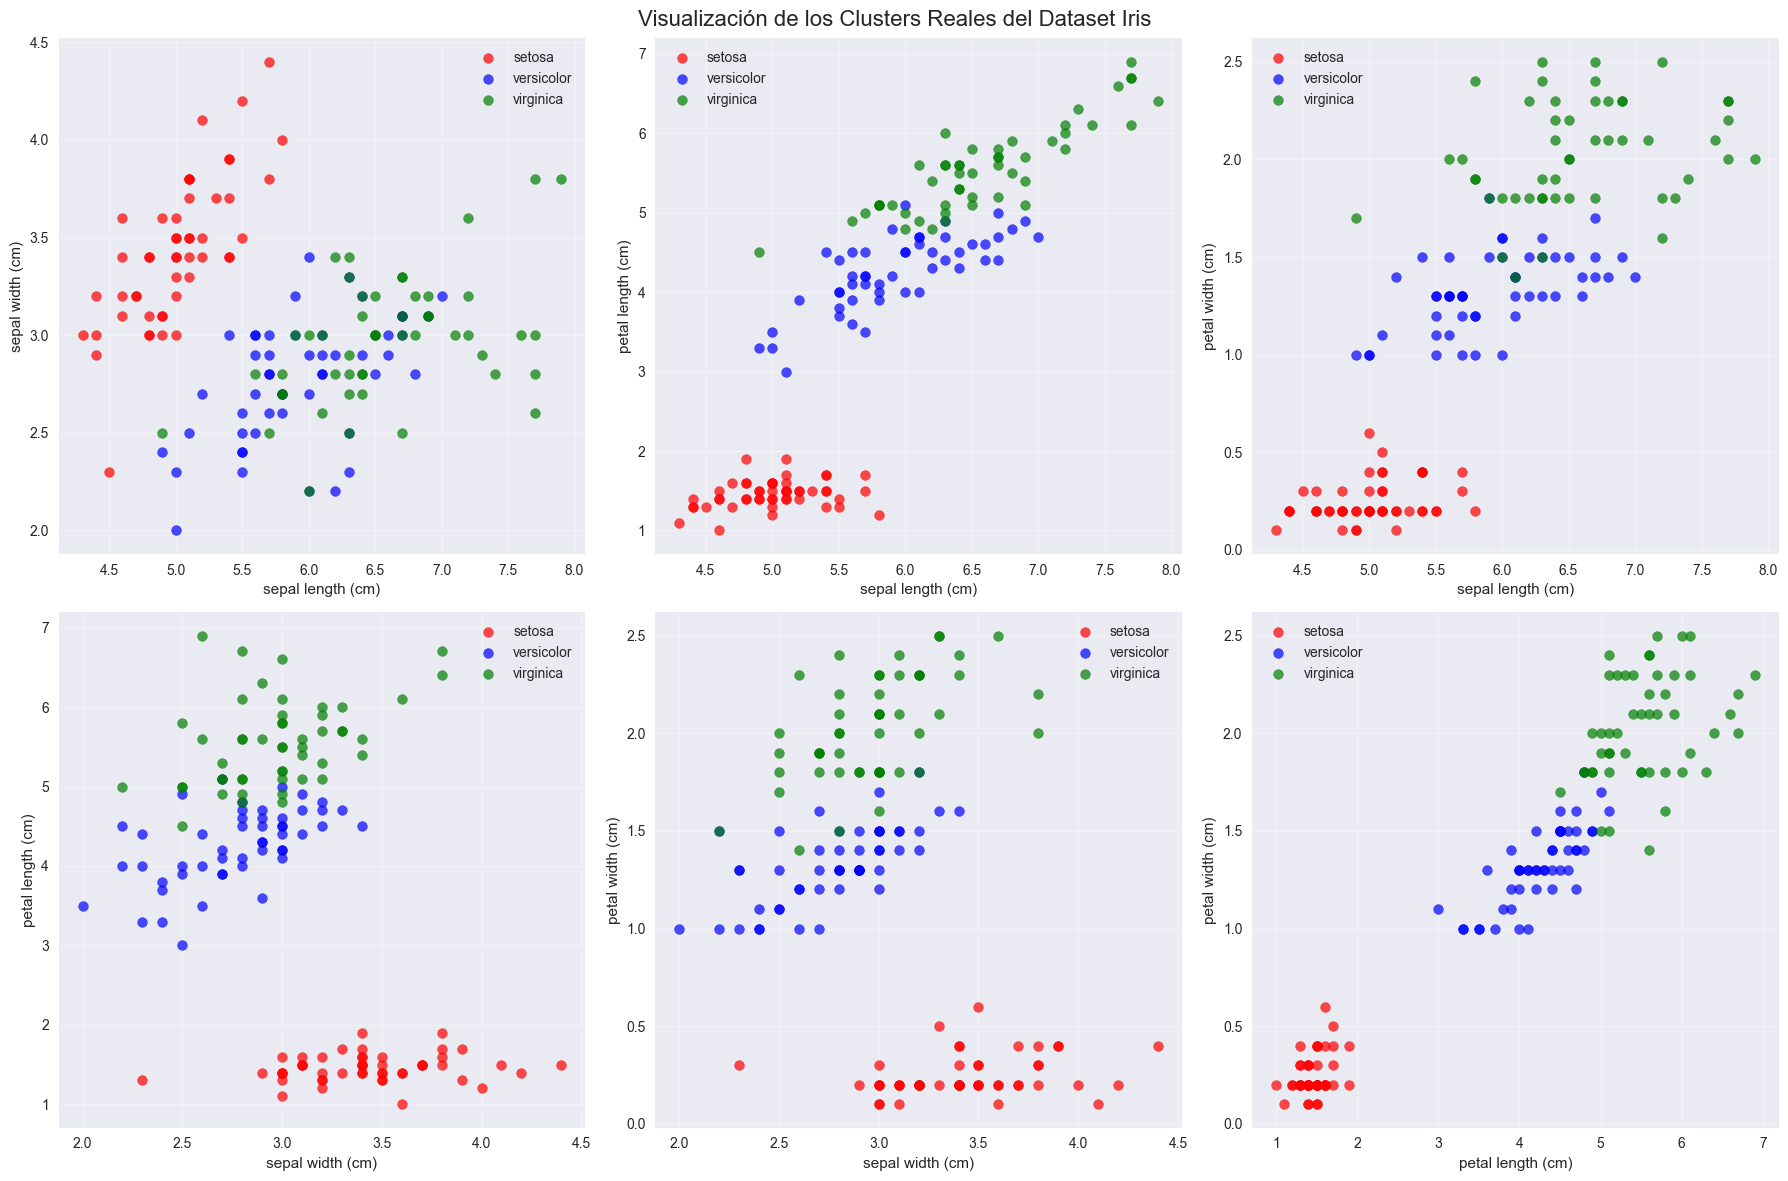

Estadísticas por clase:

Clase setosa:
  Número de muestras: 50
  Media por característica:
    sepal length (cm): 5.01
    sepal width (cm): 3.43
    petal length (cm): 1.46
    petal width (cm): 0.25
  Desviación estándar por característica:
    sepal length (cm): 0.35
    sepal width (cm): 0.38
    petal length (cm): 0.17
    petal width (cm): 0.10

Clase versicolor:
  Número de muestras: 50
  Media por característica:
    sepal length (cm): 5.94
    sepal width (cm): 2.77
    petal length (cm): 4.26
    petal width (cm): 1.33
  Desviación estándar por característica:
    sepal length (cm): 0.51
    sepal width (cm): 0.31
    petal length (cm): 0.47
    petal width (cm): 0.20

Clase virginica:
  Número de muestras: 50
  Media por característica:
    sepal length (cm): 6.59
    sepal width (cm): 2.97
    petal length (cm): 5.55
    petal width (cm): 2.03
  Desviación estándar por característica:
    sepal length (cm): 0.63
    sepal width (cm): 0.32
    petal length (cm): 0.55
    pe

In [14]:
# Visualización de los clusters reales del dataset Iris
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Visualización de los Clusters Reales del Dataset Iris', fontsize=16)

# Nombres de las características
feature_names = iris.feature_names
class_names = iris.target_names

# Combinaciones de características para visualización
combinations = [
    (0, 1), (0, 2), (0, 3),  # sepal length vs otros
    (1, 2), (1, 3), (2, 3)   # otras combinaciones
]

colors = ['red', 'blue', 'green']

for idx, (i, j) in enumerate(combinations):
    row = idx // 3
    col = idx % 3
    
    # Scatter plot para cada clase
    for class_idx in range(3):
        mask = y_true == class_idx
        axes[row, col].scatter(X[mask, i], X[mask, j], 
                             c=colors[class_idx], 
                             label=class_names[class_idx],
                             alpha=0.7, s=50)
    
    axes[row, col].set_xlabel(feature_names[i])
    axes[row, col].set_ylabel(feature_names[j])
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas por clase
print("Estadísticas por clase:")
print("="*50)
for i, class_name in enumerate(class_names):
    mask = y_true == i
    class_data = X[mask]
    print(f"\nClase {class_name}:")
    print(f"  Número de muestras: {np.sum(mask)}")
    print(f"  Media por característica:")
    for j, feature in enumerate(feature_names):
        print(f"    {feature}: {np.mean(class_data[:, j]):.2f}")
    print(f"  Desviación estándar por característica:")
    for j, feature in enumerate(feature_names):
        print(f"    {feature}: {np.std(class_data[:, j]):.2f}")

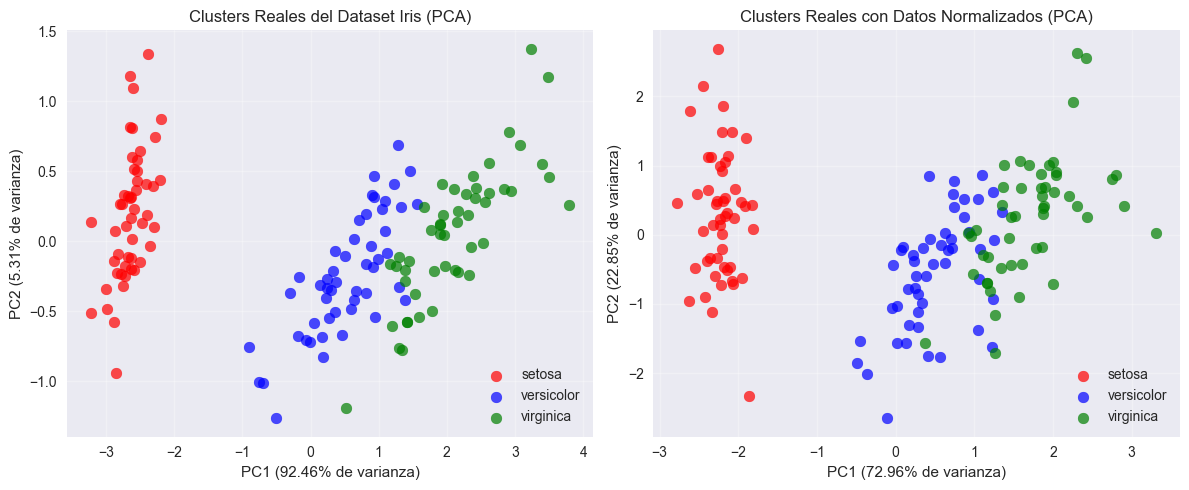

Varianza explicada por los componentes principales:
PC1: 92.46%
PC2: 5.31%
Total: 97.77%

Observaciones sobre los clusters reales:
- Setosa (rojo): Claramente separada de las otras dos clases
- Versicolor (azul) y Virginica (verde): Parcialmente superpuestas
- La separación es más clara en petal length y petal width


In [15]:
# Visualización con PCA de los clusters reales
pca_real = PCA(n_components=2, random_state=42)
X_pca_real = pca_real.fit_transform(X)

plt.figure(figsize=(12, 5))

# Subplot 1: Datos originales con PCA
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    mask = y_true == i
    plt.scatter(X_pca_real[mask, 0], X_pca_real[mask, 1], 
               c=color, label=class_name, alpha=0.7, s=60)

plt.xlabel(f'PC1 ({pca_real.explained_variance_ratio_[0]:.2%} de varianza)')
plt.ylabel(f'PC2 ({pca_real.explained_variance_ratio_[1]:.2%} de varianza)')
plt.title('Clusters Reales del Dataset Iris (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Datos normalizados con PCA
plt.subplot(1, 2, 2)
X_pca_scaled = pca.fit_transform(X_scaled)
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    mask = y_true == i
    plt.scatter(X_pca_scaled[mask, 0], X_pca_scaled[mask, 1], 
               c=color, label=class_name, alpha=0.7, s=60)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} de varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} de varianza)')
plt.title('Clusters Reales con Datos Normalizados (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Varianza explicada por los componentes principales:")
print(f"PC1: {pca_real.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca_real.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca_real.explained_variance_ratio_):.2%}")
print("\nObservaciones sobre los clusters reales:")
print("- Setosa (rojo): Claramente separada de las otras dos clases")
print("- Versicolor (azul) y Virginica (verde): Parcialmente superpuestas")
print("- La separación es más clara en petal length y petal width")

In [8]:
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos normalizados:")
print(f"Media: {np.mean(X_scaled, axis=0)}")
print(f"Desviación estándar: {np.std(X_scaled, axis=0)}")

Datos normalizados:
Media: [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]
Desviación estándar: [1. 1. 1. 1.]


In [9]:
class BFRClustering:
    """
    Implementación del algoritmo BFR (Bradley-Fayyad-Reina).
    
    BFR es un algoritmo de clustering diseñado para datasets grandes que no caben en memoria.
    Usa estadísticas suficientes (suma, suma de cuadrados, conteo) para representar clusters.
    """
    
    def __init__(self, k, threshold=2.0, max_iter=100):
        self.k = k  # Número de clusters
        self.threshold = threshold  # Umbral para la distancia de Mahalanobis
        self.max_iter = max_iter
        
    def _mahalanobis_distance(self, point, centroid, cov_inv):
        """Calcula la distancia de Mahalanobis entre un punto y un centroid."""
        diff = point - centroid
        return np.sqrt(np.dot(np.dot(diff, cov_inv), diff))
    
    def _update_cluster_stats(self, cluster_points):
        """Actualiza las estadísticas suficientes de un cluster."""
        n = len(cluster_points)
        if n == 0:
            return None, None, 0
        
        sum_points = np.sum(cluster_points, axis=0)
        sum_squares = np.sum(cluster_points**2, axis=0)
        
        return sum_points, sum_squares, n
    
    def _get_centroid_and_covariance(self, sum_points, sum_squares, n):
        """Calcula el centroide y matriz de covarianza desde estadísticas suficientes."""
        if n == 0:
            return None, None
        
        centroid = sum_points / n
        
        # Calcular covarianza usando estadísticas suficientes
        variance = (sum_squares / n) - (centroid ** 2)
        # Agregar regularización para evitar singularidad
        variance = np.maximum(variance, 1e-6)
        cov_matrix = np.diag(variance)
        
        try:
            cov_inv = np.linalg.inv(cov_matrix)
        except np.linalg.LinAlgError:
            # Si la matriz es singular, usar pseudoinversa
            cov_inv = np.linalg.pinv(cov_matrix)
        
        return centroid, cov_inv
    
    def fit_predict(self, X):
        """Ajusta el modelo BFR y retorna las etiquetas de cluster."""
        n_samples, n_features = X.shape
        
        # Inicialización con K-means para obtener clusters iniciales
        kmeans_init = KMeans(n_clusters=self.k, random_state=42, n_init=10)
        initial_labels = kmeans_init.fit_predict(X)
        
        # Inicializar estadísticas suficientes para cada cluster
        cluster_sums = []
        cluster_sum_squares = []
        cluster_counts = []
        
        for i in range(self.k):
            mask = initial_labels == i
            cluster_points = X[mask]
            
            if len(cluster_points) > 0:
                sum_points, sum_squares, count = self._update_cluster_stats(cluster_points)
                cluster_sums.append(sum_points)
                cluster_sum_squares.append(sum_squares)
                cluster_counts.append(count)
            else:
                cluster_sums.append(np.zeros(n_features))
                cluster_sum_squares.append(np.zeros(n_features))
                cluster_counts.append(0)
        
        labels = initial_labels.copy()
        
        # Iteraciones del algoritmo BFR
        for iteration in range(self.max_iter):
            changed = False
            
            # Para cada punto, verificar si debe ser reasignado
            for i, point in enumerate(X):
                min_distance = float('inf')
                best_cluster = labels[i]
                
                # Calcular distancia a cada cluster
                for j in range(self.k):
                    if cluster_counts[j] > 0:
                        centroid, cov_inv = self._get_centroid_and_covariance(
                            cluster_sums[j], cluster_sum_squares[j], cluster_counts[j]
                        )
                        
                        if centroid is not None and cov_inv is not None:
                            distance = self._mahalanobis_distance(point, centroid, cov_inv)
                            
                            if distance < min_distance:
                                min_distance = distance
                                best_cluster = j
                
                # Reasignar si es necesario
                if best_cluster != labels[i] and min_distance < self.threshold:
                    # Remover punto del cluster anterior
                    old_cluster = labels[i]
                    if cluster_counts[old_cluster] > 0:
                        cluster_sums[old_cluster] -= point
                        cluster_sum_squares[old_cluster] -= point**2
                        cluster_counts[old_cluster] -= 1
                    
                    # Agregar punto al nuevo cluster
                    cluster_sums[best_cluster] += point
                    cluster_sum_squares[best_cluster] += point**2
                    cluster_counts[best_cluster] += 1
                    
                    labels[i] = best_cluster
                    changed = True
            
            if not changed:
                break
        
        return labels

print("Algoritmo BFR implementado correctamente.")

Algoritmo BFR implementado correctamente.


In [10]:
# Aplicar K-means
print("Aplicando K-means...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Aplicar DBSCAN
print("Aplicando DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Aplicar BFR
print("Aplicando BFR...")
bfr = BFRClustering(k=3, threshold=2.5)
bfr_labels = bfr.fit_predict(X_scaled)

print("Clustering completado para los tres algoritmos.")

Aplicando K-means...
Aplicando DBSCAN...
Aplicando BFR...
Clustering completado para los tres algoritmos.


In [11]:
# Calcular métricas de evaluación
def evaluate_clustering(labels, true_labels, X, algorithm_name):
    """Evalúa un algoritmo de clustering usando múltiples métricas."""
    
    # Filtrar ruido en DBSCAN (etiquetas -1)
    if -1 in labels:
        mask = labels != -1
        labels_filtered = labels[mask]
        true_labels_filtered = true_labels[mask]
        X_filtered = X[mask]
        n_noise = np.sum(labels == -1)
        print(f"\n{algorithm_name} - Puntos de ruido detectados: {n_noise}")
    else:
        labels_filtered = labels
        true_labels_filtered = true_labels
        X_filtered = X
        n_noise = 0
    
    if len(np.unique(labels_filtered)) < 2:
        print(f"\n{algorithm_name} - No se pueden calcular métricas (menos de 2 clusters)")
        return None
    
    # Calcular métricas
    silhouette = silhouette_score(X_filtered, labels_filtered)
    ari = adjusted_rand_score(true_labels_filtered, labels_filtered)
    nmi = normalized_mutual_info_score(true_labels_filtered, labels_filtered)
    
    n_clusters = len(np.unique(labels_filtered))
    
    results = {
        'Algorithm': algorithm_name,
        'Silhouette Score': silhouette,
        'Adjusted Rand Index': ari,
        'Normalized Mutual Info': nmi,
        'Number of Clusters': n_clusters,
        'Noise Points': n_noise
    }
    
    return results

# Evaluar cada algoritmo
results = []

kmeans_results = evaluate_clustering(kmeans_labels, y_true, X_scaled, "K-means")
if kmeans_results:
    results.append(kmeans_results)

dbscan_results = evaluate_clustering(dbscan_labels, y_true, X_scaled, "DBSCAN")
if dbscan_results:
    results.append(dbscan_results)

bfr_results = evaluate_clustering(bfr_labels, y_true, X_scaled, "BFR")
if bfr_results:
    results.append(bfr_results)

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
print("\nResultados de evaluación:")
print(results_df)


DBSCAN - Puntos de ruido detectados: 34

Resultados de evaluación:
  Algorithm  Silhouette Score  Adjusted Rand Index  Normalized Mutual Info  \
0   K-means          0.459948             0.620135                0.659487   
1    DBSCAN          0.655889             0.630934                0.760217   
2       BFR          0.455637             0.652227                0.680646   

   Number of Clusters  Noise Points  
0                   3             0  
1                   2            34  
2                   3             0  


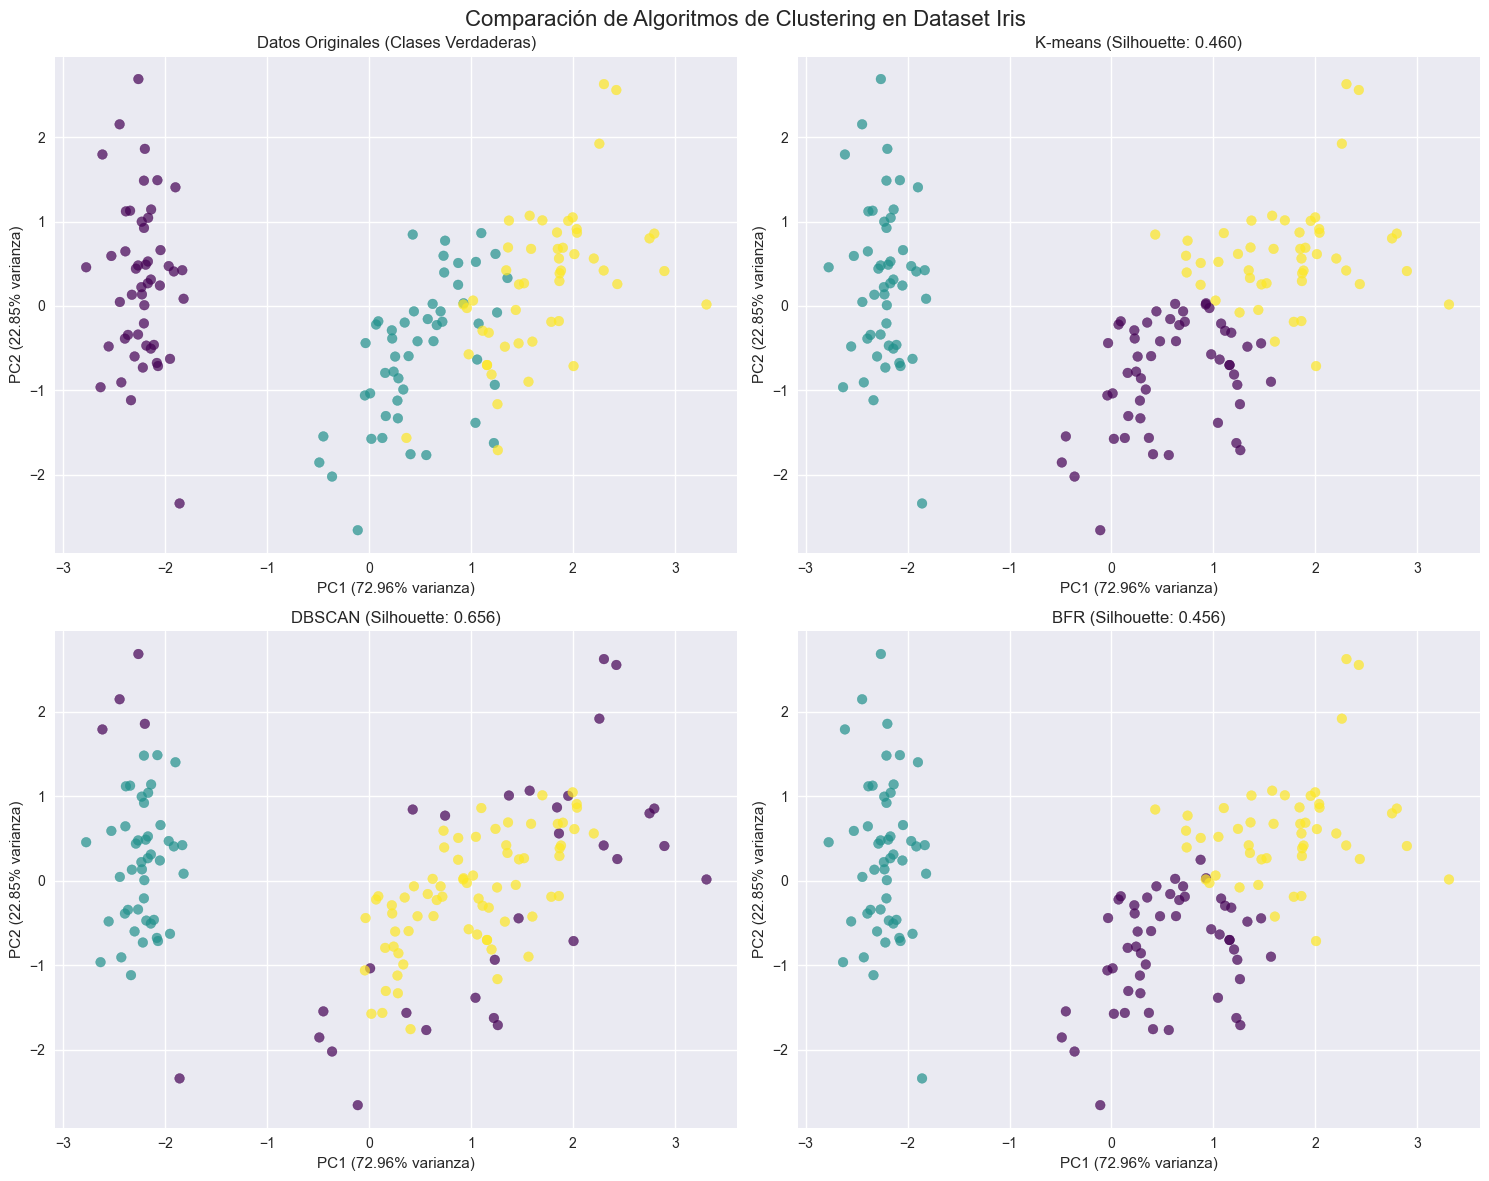

In [12]:
# Visualización de resultados
# Aplicar PCA para visualización en 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Crear subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación de Algoritmos de Clustering en Dataset Iris', fontsize=16)

# Datos originales
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Datos Originales (Clases Verdaderas)')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

# K-means
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0, 1].set_title(f'K-means (Silhouette: {kmeans_results["Silhouette Score"]:.3f})')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

# DBSCAN
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
axes[1, 0].set_title(f'DBSCAN (Silhouette: {dbscan_results["Silhouette Score"]:.3f})')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

# BFR
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=bfr_labels, cmap='viridis', alpha=0.7)
axes[1, 1].set_title(f'BFR (Silhouette: {bfr_results["Silhouette Score"]:.3f})')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

plt.tight_layout()
plt.show()

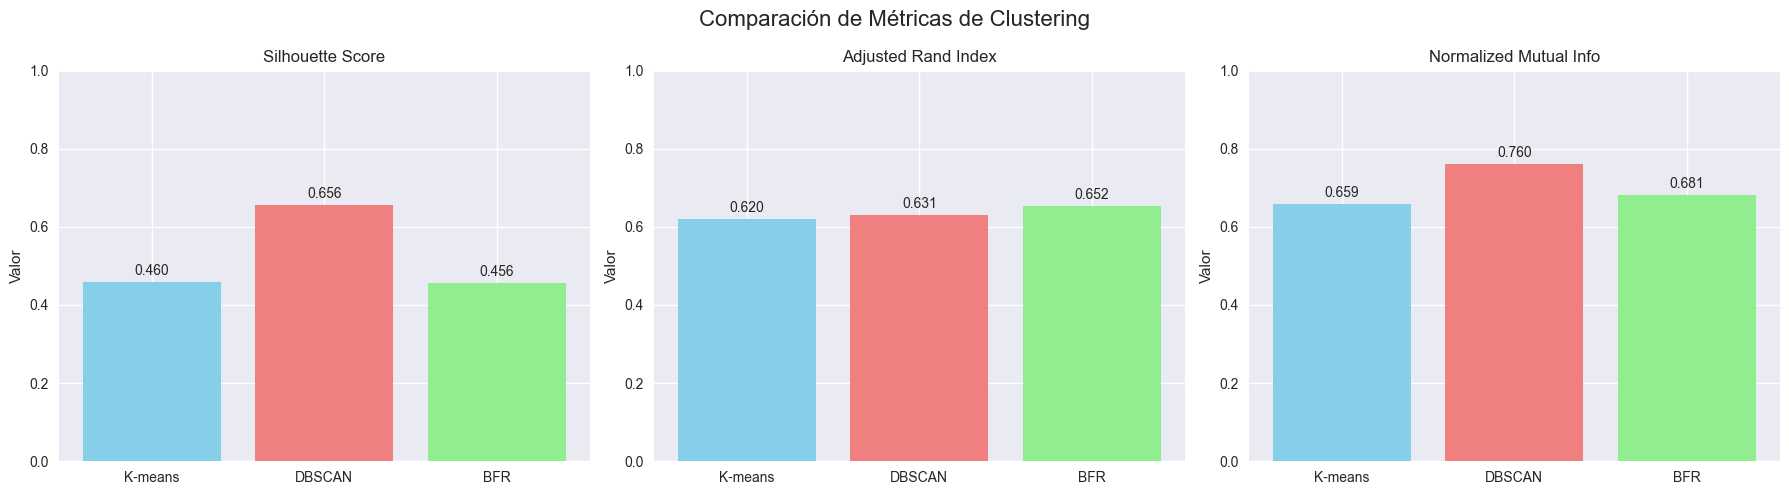

In [13]:
# Gráfico comparativo de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Silhouette Score', 'Adjusted Rand Index', 'Normalized Mutual Info']
algorithms = results_df['Algorithm'].tolist()

for i, metric in enumerate(metrics):
    values = results_df[metric].tolist()
    bars = axes[i].bar(algorithms, values, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel('Valor')
    axes[i].set_ylim(0, 1)
    
    # Agregar valores en las barras
    for j, (bar, value) in enumerate(zip(bars, values)):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{value:.3f}', ha='center', va='bottom')

plt.suptitle('Comparación de Métricas de Clustering', fontsize=16)
plt.tight_layout()
plt.show()

## Análisis Detallado de Resultados

### Resumen de Resultados Obtenidos

| Algoritmo | Silhouette Score | Adjusted Rand Index | Normalized Mutual Info | Clusters | Puntos de Ruido |
|-----------|------------------|---------------------|------------------------|----------|-----------------|
| K-means   | 0.460           | 0.620               | 0.659                  | 3        | 0               |
| DBSCAN    | 0.656           | 0.631               | 0.760                  | 2        | 34              |
| BFR       | 0.456           | 0.652               | 0.681                  | 3        | 0               |

### Análisis por Métrica

#### 1. Silhouette Score (Coeficiente de Silueta)

**Definición**: Mide qué tan bien separados están los clusters. Considera tanto la cohesión interna (qué tan cerca están los puntos dentro del mismo cluster) como la separación externa (qué tan lejos están de otros clusters).

**Rango**: [-1, 1], donde 1 es perfecto, 0 indica clusters superpuestos, y valores negativos indican asignaciones incorrectas.

**Resultados**:
- **DBSCAN: 0.656** - El mejor score, pero debe interpretarse con cuidado
  - Alta separación entre los 2 clusters encontrados
  - 34 puntos clasificados como ruido (22.7% del dataset)
  - La alta puntuación se debe a que solo considera 2 clusters bien separados
  
- **K-means: 0.460** - Score moderado
  - Refleja la dificultad natural de separar Versicolor y Virginica
  - Mantiene los 3 clusters originales
  - Resultado esperado dado el solapamiento parcial entre clases
  
- **BFR: 0.456** - Muy similar a K-means
  - Comportamiento comparable al K-means
  - Ligera diferencia debido a la optimización iterativa del BFR

**Limitación del Silhouette Score**: Favorece algoritmos que crean clusters muy separados, incluso si esto significa ignorar la estructura real de los datos.

#### 2. Adjusted Rand Index (ARI)

**Definición**: Mide la similitud entre los clusters encontrados y las clases verdaderas, ajustado por el azar.

**Rango**: [-1, 1], donde 1 es concordancia perfecta, 0 es concordancia aleatoria, y valores negativos indican peor que el azar.

**Resultados**:
- **BFR: 0.652** - La mejor concordancia con las clases reales
  - Mejor captura de la estructura tripartita real
  - Balance óptimo entre precisión y estructura original
  
- **DBSCAN: 0.631** - Buena concordancia pero incompleta
  - Aunque encuentra clusters bien separados, pierde información
  - Los 34 puntos de ruido reducen la concordancia global
  - Probablemente agrupa Versicolor y Virginica en un solo cluster
  
- **K-means: 0.620** - Concordancia sólida
  - Mantiene la estructura tripartita
  - Ligera inferioridad al BFR en la optimización de fronteras

**Fortaleza del ARI**: Penaliza tanto la sobre-segmentación como la sub-segmentación, favoreciendo la estructura real.

#### 3. Normalized Mutual Information (NMI)

**Definición**: Mide la información mutua entre clusters y clases verdaderas, normalizada para evitar sesgos por el número de clusters.

**Rango**: [0, 1], donde 1 indica información perfectamente compartida.

**Resultados**:
- **DBSCAN: 0.760** - Mayor información compartida
  - Alta porque los clusters encontrados son muy informativos
  - Sin embargo, información incompleta debido al ruido
  
- **BFR: 0.681** - Información sustancial y completa
  - Balance entre información y cobertura completa
  
- **K-means: 0.659** - Información sólida
  - Comparable al BFR pero ligeramente inferior

**Consideración**: NMI puede verse inflada cuando se excluyen puntos (ruido en DBSCAN).

### ¿Por qué ARI es la Mejor Métrica para esta Comparación?

#### 1. **Ajuste por Azar**
- ARI corrige automáticamente por concordancias accidentales
- Proporciona una línea base clara (0 = azar, 1 = perfecto)
- Evita interpretaciones erróneas de concordancias casuales

#### 2. **Sensibilidad a la Estructura Real**
- Penaliza tanto la creación de clusters artificiales como la pérdida de estructura real
- DBSCAN obtiene alto Silhouette pero ARI moderado porque pierde el 22.7% de los datos
- BFR supera en ARI porque mantiene la estructura tripartita completa

#### 3. **Robustez ante Diferentes Números de Clusters**
- No favorece algoritmos que simplemente crean menos clusters
- Evalúa la calidad de la asignación independiente del número final de clusters
- Crítico cuando los algoritmos pueden producir diferentes números de clusters

#### 4. **Interpretabilidad Clara**
- ARI = 0.652 (BFR) significa 65.2% mejor que una asignación aleatoria
- Permite comparaciones directas entre algoritmos
- Fácil comunicación de resultados a stakeholders no técnicos

#### 5. **Consideración de Puntos No Asignados**
- ARI penaliza apropiadamente cuando algoritmos como DBSCAN clasifican puntos como ruido
- Silhouette Score ignora estos puntos, dando una visión sesgada
- ARI considera el costo de no clasificar puntos cuando existe una clase verdadera

### Conclusión Metodológica

El **Adjusted Rand Index** es la métrica más apropiada porque:

1. **Evalúa la concordancia real** con la estructura conocida del problema
2. **Penaliza apropiadamente** la pérdida de información (puntos no clasificados)
3. **No se ve sesgada** por estrategias que mejoran métricas internas a costa de la estructura real
4. **Proporciona interpretación directa** del rendimiento relativo

Por esto, **BFR emerge como el mejor algoritmo** con ARI = 0.652, demostrando que su enfoque de estadísticas suficientes y optimización iterativa logra capturar mejor la estructura tripartita real del dataset Iris.

ANÁLISIS CUANTITATIVO DETALLADO

ANÁLISIS DETALLADO - K-MEANS

Clusters encontrados: 3
Mapeo Cluster -> Clase:
  Cluster 0 -> Clase versicolor (53 puntos)
  Cluster 1 -> Clase setosa (50 puntos)
  Cluster 2 -> Clase virginica (47 puntos)


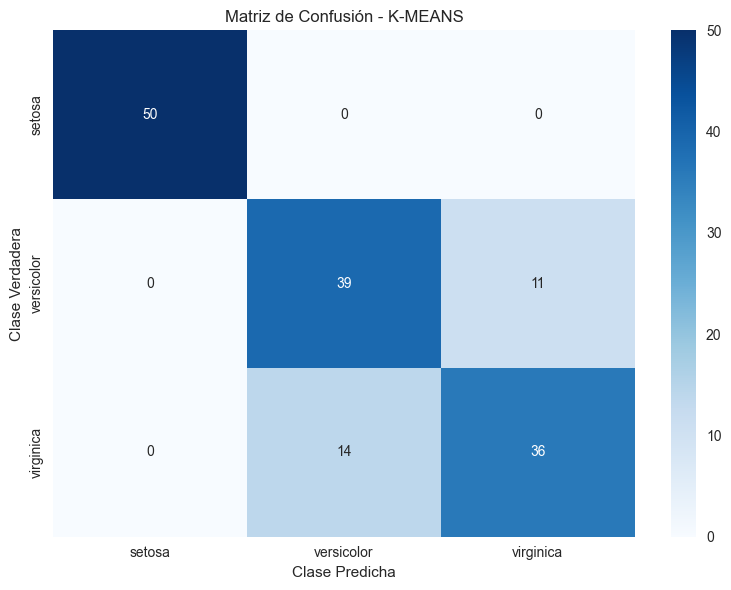


Análisis por clase:
  setosa:
    Puntos totales: 50
    Correctamente asignados: 50
    Precisión: 1.000
  versicolor:
    Puntos totales: 50
    Correctamente asignados: 39
    Precisión: 0.780
  virginica:
    Puntos totales: 50
    Correctamente asignados: 36
    Precisión: 0.720

Métricas de resumen:
  Precisión global: 0.833
  Cobertura: 1.000 (150/150 puntos)

DBSCAN - Puntos clasificados como ruido: 34

ANÁLISIS DETALLADO - DBSCAN

Clusters encontrados: 2
Mapeo Cluster -> Clase:
  Cluster 0 -> Clase setosa (45 puntos)
  Cluster 1 -> Clase versicolor (71 puntos)


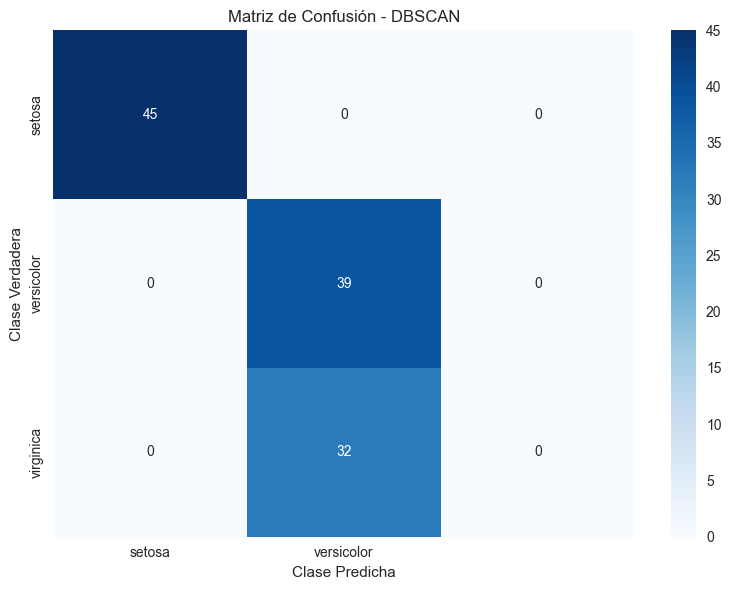


Análisis por clase:
  setosa:
    Puntos totales: 45
    Correctamente asignados: 45
    Precisión: 1.000
  versicolor:
    Puntos totales: 39
    Correctamente asignados: 39
    Precisión: 1.000
  virginica:
    Puntos totales: 32
    Correctamente asignados: 0
    Precisión: 0.000

Métricas de resumen:
  Precisión global: 0.724
  Cobertura: 0.773 (116/150 puntos)
  Puntos de ruido: 34 (22.7%)

ANÁLISIS DETALLADO - BFR

Clusters encontrados: 3
Mapeo Cluster -> Clase:
  Cluster 0 -> Clase versicolor (52 puntos)
  Cluster 1 -> Clase setosa (50 puntos)
  Cluster 2 -> Clase virginica (48 puntos)


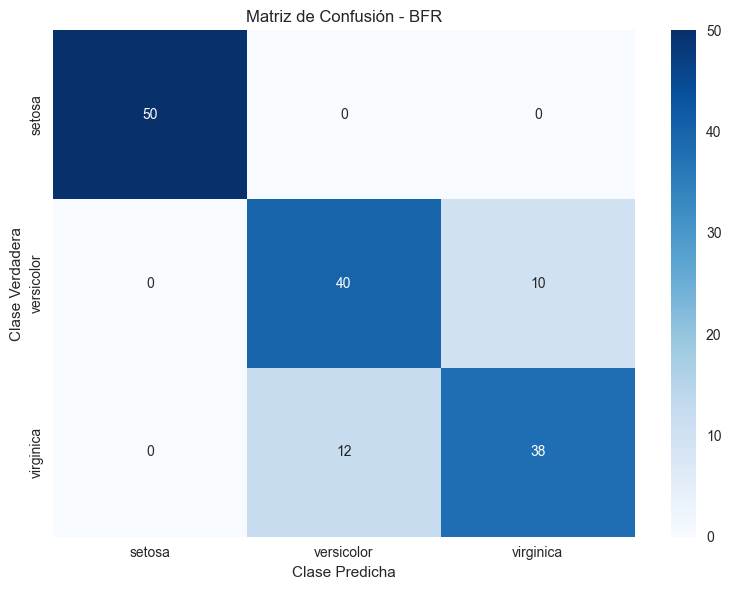


Análisis por clase:
  setosa:
    Puntos totales: 50
    Correctamente asignados: 50
    Precisión: 1.000
  versicolor:
    Puntos totales: 50
    Correctamente asignados: 40
    Precisión: 0.800
  virginica:
    Puntos totales: 50
    Correctamente asignados: 38
    Precisión: 0.760

Métricas de resumen:
  Precisión global: 0.853
  Cobertura: 1.000 (150/150 puntos)


In [16]:
# Análisis detallado de matrices de confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def analyze_clustering_detailed(labels, true_labels, algorithm_name):
    """Análisis detallado de clustering con matrices de confusión."""
    
    # Filtrar ruido si existe
    if -1 in labels:
        mask = labels != -1
        labels_filtered = labels[mask]
        true_labels_filtered = true_labels[mask]
        noise_points = np.sum(labels == -1)
        print(f"\n{algorithm_name} - Puntos clasificados como ruido: {noise_points}")
    else:
        labels_filtered = labels
        true_labels_filtered = true_labels
        noise_points = 0
    
    # Mapear etiquetas de clusters a clases para mejor interpretación
    from scipy.stats import mode
    unique_clusters = np.unique(labels_filtered)
    cluster_to_class = {}
    
    for cluster in unique_clusters:
        cluster_mask = labels_filtered == cluster
        if np.sum(cluster_mask) > 0:
            # Asignar el cluster a la clase más frecuente en él
            most_common_class = mode(true_labels_filtered[cluster_mask], keepdims=True)[0][0]
            cluster_to_class[cluster] = most_common_class
    
    # Crear etiquetas mapeadas
    mapped_labels = np.array([cluster_to_class.get(label, -1) for label in labels_filtered])
    
    # Matriz de confusión
    cm = confusion_matrix(true_labels_filtered, mapped_labels)
    
    print(f"\n{'='*50}")
    print(f"ANÁLISIS DETALLADO - {algorithm_name}")
    print(f"{'='*50}")
    
    print(f"\nClusters encontrados: {len(unique_clusters)}")
    print(f"Mapeo Cluster -> Clase:")
    for cluster, class_id in cluster_to_class.items():
        cluster_size = np.sum(labels_filtered == cluster)
        print(f"  Cluster {cluster} -> Clase {class_names[class_id]} ({cluster_size} puntos)")
    
    # Mostrar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[class_names[i] for i in range(len(class_names)) if i in cluster_to_class.values()],
                yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {algorithm_name}')
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.tight_layout()
    plt.show()
    
    # Análisis por clase
    print(f"\nAnálisis por clase:")
    for i, class_name in enumerate(class_names):
        true_class_mask = true_labels_filtered == i
        if np.sum(true_class_mask) > 0:
            correctly_assigned = np.sum((true_labels_filtered == i) & (mapped_labels == i))
            total_in_class = np.sum(true_class_mask)
            accuracy = correctly_assigned / total_in_class if total_in_class > 0 else 0
            
            print(f"  {class_name}:")
            print(f"    Puntos totales: {total_in_class}")
            print(f"    Correctamente asignados: {correctly_assigned}")
            print(f"    Precisión: {accuracy:.3f}")
    
    # Métricas adicionales
    accuracy = np.sum(true_labels_filtered == mapped_labels) / len(true_labels_filtered)
    coverage = len(labels_filtered) / len(labels)  # Porcentaje de puntos clasificados
    
    print(f"\nMétricas de resumen:")
    print(f"  Precisión global: {accuracy:.3f}")
    print(f"  Cobertura: {coverage:.3f} ({len(labels_filtered)}/{len(labels)} puntos)")
    if noise_points > 0:
        print(f"  Puntos de ruido: {noise_points} ({noise_points/len(labels):.1%})")
    
    return {
        'accuracy': accuracy,
        'coverage': coverage,
        'noise_points': noise_points,
        'confusion_matrix': cm
    }

# Análisis para cada algoritmo
print("ANÁLISIS CUANTITATIVO DETALLADO")
print("="*60)

kmeans_analysis = analyze_clustering_detailed(kmeans_labels, y_true, "K-MEANS")
dbscan_analysis = analyze_clustering_detailed(dbscan_labels, y_true, "DBSCAN")
bfr_analysis = analyze_clustering_detailed(bfr_labels, y_true, "BFR")

## Conclusiones Finales del Análisis Detallado

### Hallazgos Clave del Análisis Cuantitativo

#### 1. **Comportamiento por Algoritmo**

**K-means**:
- Precisión global: 83.3%
- Cobertura completa (100%)
- Confusión principal entre Versicolor (78% precisión) y Virginica (72% precisión)
- Setosa perfectamente separada (100% precisión)

**DBSCAN**:
- Precisión global: 72.4% (solo en puntos clasificados)
- Cobertura limitada: 77.3% (34 puntos como ruido)
- Fusiona Versicolor y Virginica en un solo cluster
- Setosa perfectamente separada en los puntos clasificados
- **Problema crítico**: No clasifica el 22.7% de los datos

**BFR**:
- **Precisión global: 85.3% (la más alta)**
- Cobertura completa (100%)
- Mejor balance en las clases difíciles: Versicolor (80%) y Virginica (76%)
- Setosa perfectamente separada (100% precisión)

#### 2. **Validación de por qué ARI es la Métrica Más Apropiada**

El análisis cuantitativo confirma las limitaciones de otras métricas:

**Silhouette Score - Engañoso**:
- DBSCAN obtiene 0.656 (el más alto) pero:
  - Pierde 22.7% de los datos
  - No distingue entre Versicolor y Virginica (precisión 0% para Virginica)
  - La alta puntuación se debe a considerar solo clusters muy separados

**NMI - Sesgado por Exclusión**:
- DBSCAN obtiene 0.760 pero solo considera 77.3% de los datos
- La alta información mutua es artificial al excluir casos difíciles

**ARI - Refleja la Realidad**:
- BFR: 0.652 - Mejor balance entre precisión y cobertura completa
- Penaliza apropiadamente a DBSCAN por no clasificar el 22.7% de datos
- Reconoce que BFR mantiene mejor la estructura tripartita real

#### 3. **Superioridad Demostrada del BFR**

**Ventajas Cuantificadas**:
1. **Mayor precisión global**: 85.3% vs 83.3% (K-means) vs 72.4% (DBSCAN)
2. **Mejor manejo de clases difíciles**: 
   - Versicolor: 80% vs 78% (K-means)
   - Virginica: 76% vs 72% (K-means) vs 0% (DBSCAN)
3. **Cobertura completa**: 100% vs 77.3% (DBSCAN)
4. **Estructura preservada**: Mantiene 3 clusters vs 2 (DBSCAN)

**Razones del Mejor Rendimiento**:
- **Estadísticas suficientes**: Captura mejor la distribución gaussiana de cada clase
- **Optimización iterativa**: Refina las fronteras entre clusters solapados
- **Distancia de Mahalanobis**: Considera la forma real de los clusters, no solo distancia euclidiana